In [1]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
plt.rcParams['figure.figsize'] = (16./3, 9./3)

def visualize_l2(pred, x_train, y_train, x_test, y_test):
    from matplotlib.patches import Rectangle
    plt.plot(x_train, y_train, '.k', markerfacecolor='none', label='Train Data')
    plt.plot(x_train, pred,  '--k', label='Model')
    plt.plot(x_test, y_test, 'xk', markersize=3, markerfacecolor='none', label='Test Data')
    currentAxis = plt.gca()
    for k, (xx,yy) in enumerate(zip(x_train, y_train)):
        error = pred[k] - yy
        currentAxis.add_patch(Rectangle((xx, yy), 
                                        error, error,
                              alpha=0.1, facecolor='gray', edgecolor='k'))
    plt.grid()
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')

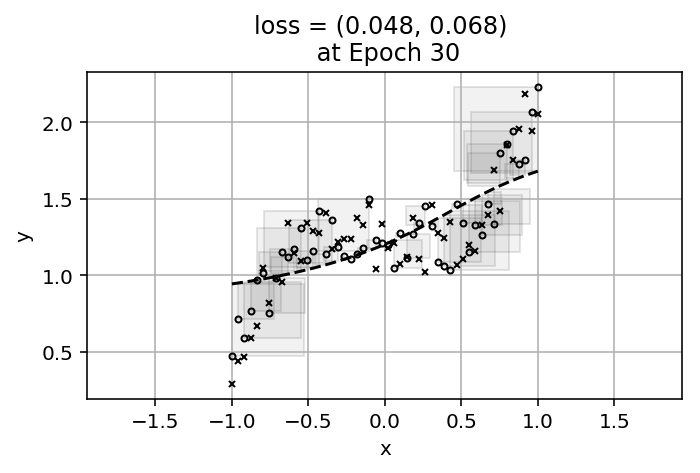

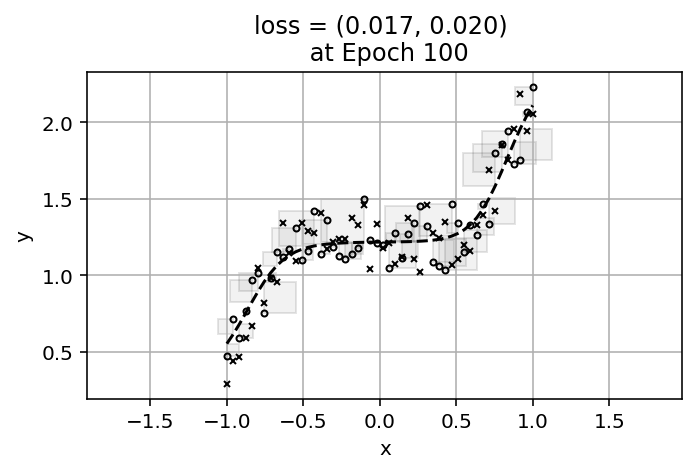

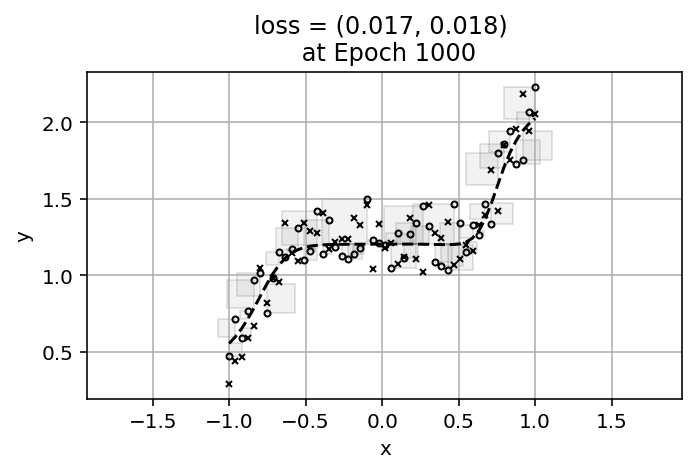

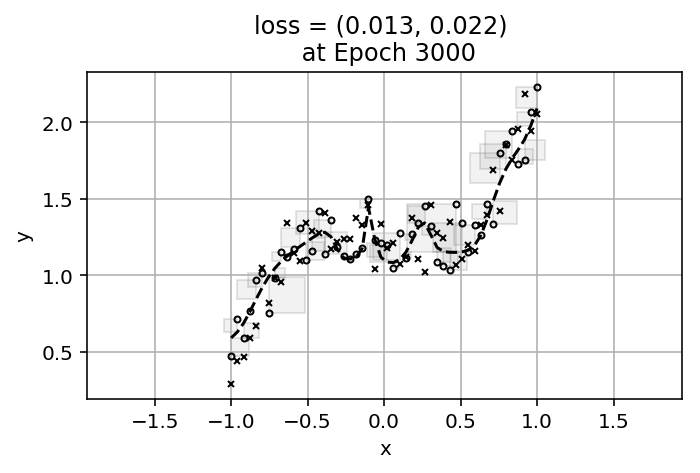

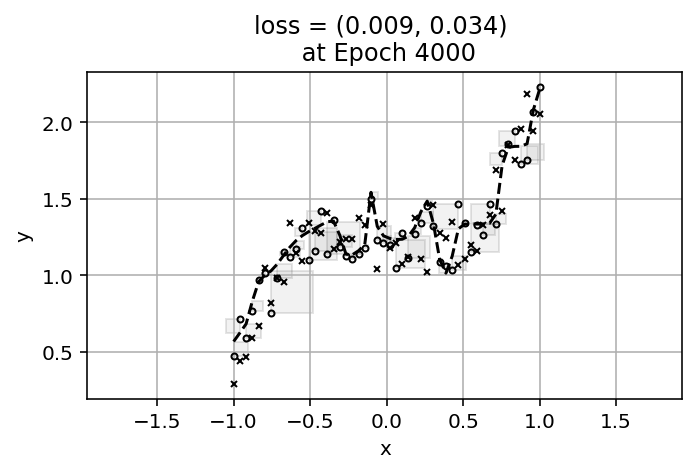

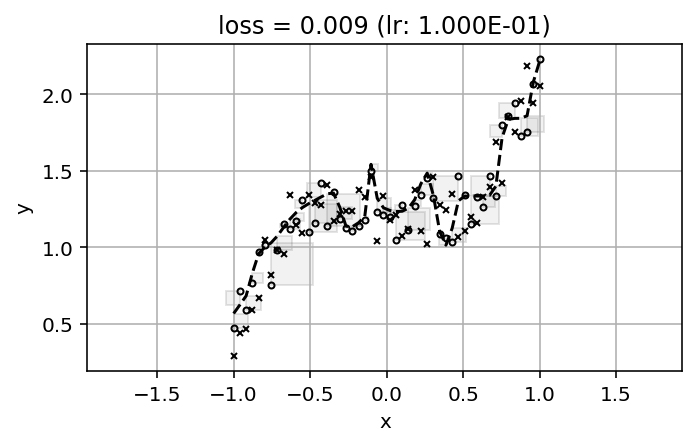

In [3]:
# 학습용 데이터 생성
np.random.seed(327)
x_train = np.linspace(-1,1,50)
y_train = x_train**3 + 0.1 * x_train**2 -0.15 * x_train + 1.0 + 0.5 * np.random.rand(len(x_train))
rand_init = tf.random_normal_initializer(seed=624)

# 테스트용 데이터 생성
x_test = np.linspace(-1,1,50)
y_test = x_test**3 + 0.1 * x_test**2 -0.15 * x_test + 1.0 + 0.5 * np.random.rand(len(x_test))

# 특성값
features_train = np.array([[xval] for xval in x_train])
labels_train = y_train.reshape(-1, 1)

features_test = np.array([[xval] for xval in x_test])
labels_test = y_test.reshape(-1, 1)

# 은닉층들의 노드 개수
num_hidden1 = 10
num_hidden2 = 5

# 입력층
x = tf.placeholder(tf.float32, shape=[None, 1])

# 은닉층 1
hidden1 =  tf.contrib.layers.fully_connected(x, num_hidden1,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init)

# 은닉층 2
hidden2 =  tf.contrib.layers.fully_connected(hidden1, num_hidden2,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init)

# 출력층
yhat =  tf.contrib.layers.fully_connected(hidden2, 1,
                                          activation_fn=None,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init)

# 손실함수
y = tf.placeholder(tf.float32, shape=[None, 1])
loss = tf.losses.mean_squared_error(y, yhat)

# 수치최적화 알고리즘
MaxEpoch = 4000
lr = 0.1
batch_size = 10
optimizer = tf.train.AdamOptimizer(lr)
train = optimizer.minimize(loss)

# 데이터 섞기
np.random.seed(320)
shuffled_id = np.arange(0, len(x_train))
np.random.shuffle(shuffled_id)
shuffled_x_train = features_train[shuffled_id]
shuffled_y_train = labels_train[shuffled_id]

# 손실함수 기록용 변수
loss_train_history = []
loss_test_history = []

# 스토캐스틱 방법
from helper import generate_batches
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(MaxEpoch+1):
        for x_batch, y_batch in generate_batches(batch_size, 
                                                 shuffled_x_train, 
                                                 shuffled_y_train):
            sess.run(train, feed_dict={x:x_batch, y:y_batch})

        loss_train = sess.run(loss, feed_dict={x:features_train, 
                                               y:labels_train})
        loss_test = sess.run(loss, feed_dict={x:features_test, 
                                              y:labels_test})
        
        loss_train_history.append(loss_train)
        loss_test_history.append(loss_test)
        
        if epoch in [30, 100, 1000, 3000, 4000]:
            loss_val_train, pred = sess.run([loss, yhat], feed_dict={x:features_train, y:labels_train})
            loss_val_test, pred = sess.run([loss, yhat], feed_dict={x:features_test, y:labels_test})
            plt.title("loss = ({:1.3f}, {:1.3f}) \n at Epoch {}".format(loss_val_train, loss_val_test, epoch))
            visualize_l2(pred, x_train, y_train, x_test, y_test)
            plt.show()
    
    final_loss, pred = sess.run([loss, yhat], feed_dict={x:features_train, y:labels_train})

plt.title("loss = {:1.3f} (lr: {:1.3E})".format(final_loss, lr))
visualize_l2(pred, x_train, y_train, x_test, y_test)
plt.show()

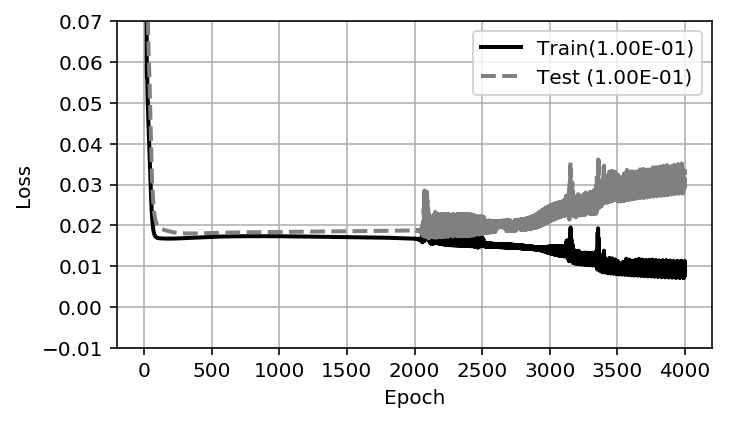

In [4]:
plt.plot(loss_train_history, '-k', label='Train({:1.2E})'.format(lr), linewidth=2)
plt.plot(loss_test_history, '--', color='gray', label='Test ({:1.2E})'.format(lr), linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([-.01, 0.07])
plt.legend()
plt.grid()
plt.show()

In [5]:
# 은닉층 1의 Weight
W1 = tf.Variable(tf.random_normal([1, num_hidden1], seed=624))
b1 = tf.Variable(tf.random_normal([num_hidden1], seed=624))

# 은닉층 2의 Weight
W2 = tf.Variable(tf.random_normal([num_hidden1, num_hidden2], seed=624))
b2 = tf.Variable(tf.random_normal([num_hidden2], seed=624))

# 출력층의 Weight
W3 = tf.Variable(tf.random_normal([num_hidden2, 1], seed=624))
b3 = tf.Variable(tf.random_normal([1], seed=624))

# 입력층
x = tf.placeholder(tf.float32, shape=[None, 1])

# 은닉층 1
hidden1 = tf.nn.sigmoid(tf.matmul(x, W1) + b1)

# 은닉층 2
hidden2 = tf.nn.sigmoid(tf.matmul(hidden1, W2) + b2)

# 출력층
yhat = tf.matmul(hidden2, W3) + b3

# Weight l2_loss
y = tf.placeholder(tf.float32, shape=[None, 1])
loss = tf.losses.mean_squared_error(y, yhat)

l2_loss = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3)

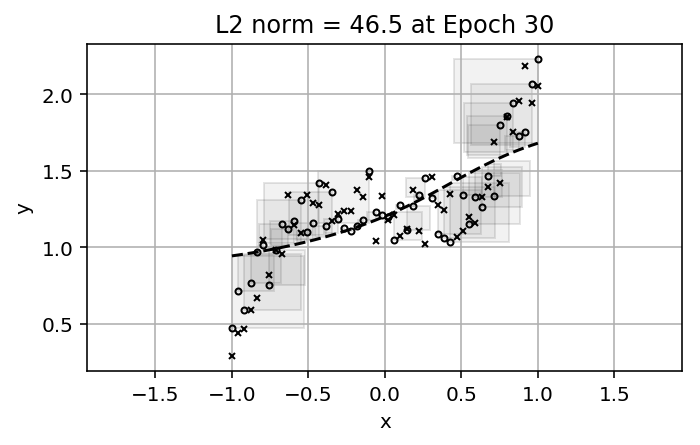

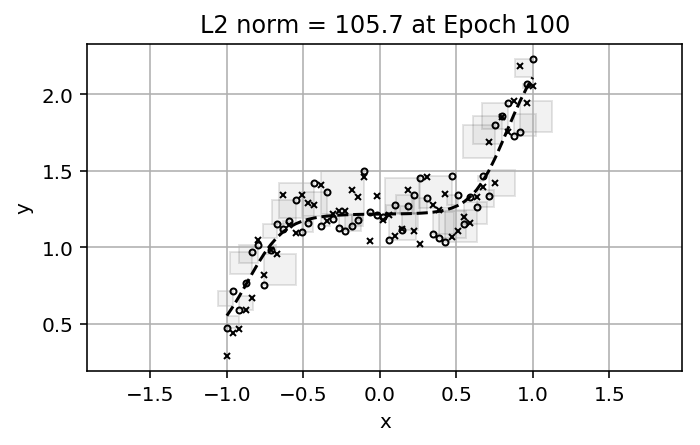

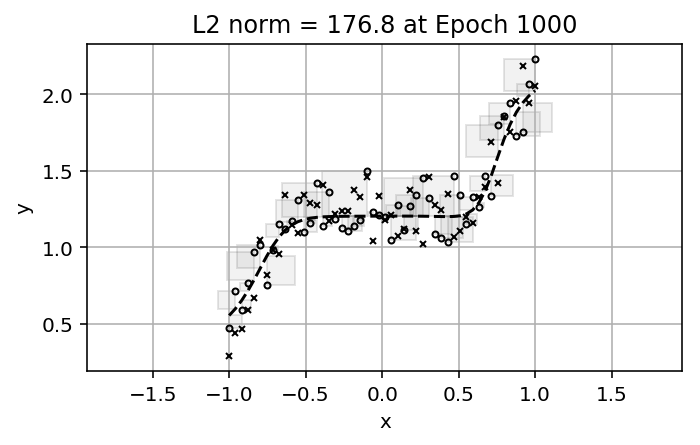

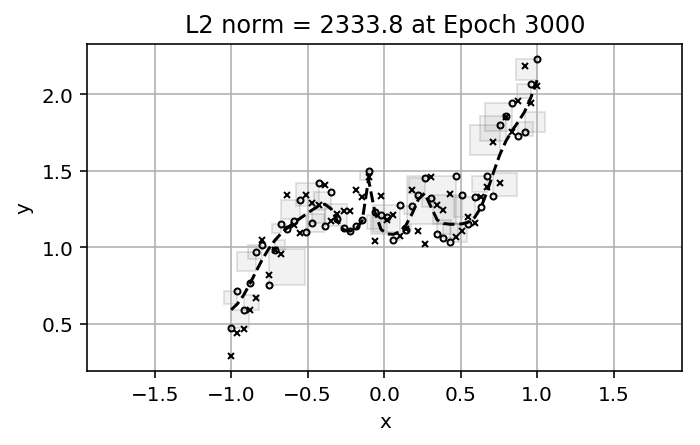

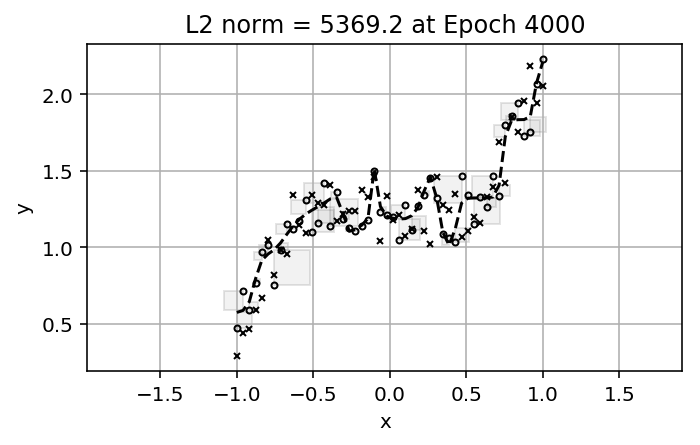

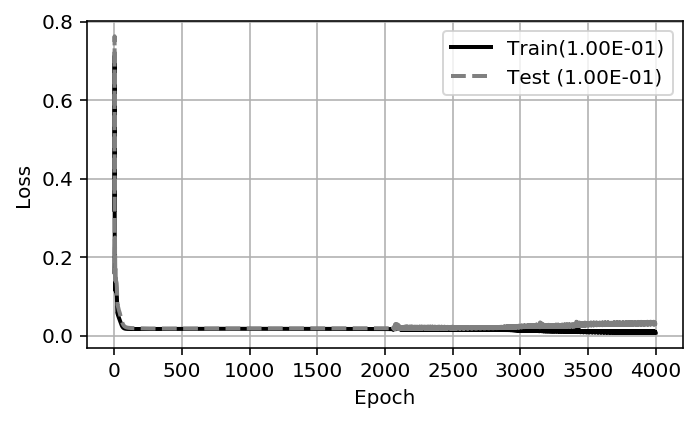

In [6]:
# 수치최적화 알고리즘
MaxEpoch = 4000
lr = 0.1
batch_size = 10
optimizer = tf.train.AdamOptimizer(lr)
train = optimizer.minimize(loss)

# 데이터 섞기
np.random.seed(320)
shuffled_id = np.arange(0, len(x_train))
np.random.shuffle(shuffled_id)
shuffled_x_train = features_train[shuffled_id]
shuffled_y_train = labels_train[shuffled_id]

# 손실함수 기록용 변수
loss_train_history = []
loss_test_history = []

# 스토캐스틱 방법
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(MaxEpoch+1):
        for x_batch, y_batch in generate_batches(batch_size, 
                                                 shuffled_x_train, 
                                                 shuffled_y_train):
            sess.run(train, feed_dict={x:x_batch, y:y_batch})

        loss_train = sess.run(loss, feed_dict={x:features_train, 
                                               y:labels_train})
        loss_test = sess.run(loss, feed_dict={x:features_test, 
                                              y:labels_test})
        loss_train_history.append(loss_train)
        loss_test_history.append(loss_test)
    
        if epoch in [30, 100, 1000, 3000, 4000]:
            l2_loss_val, pred = sess.run([l2_loss, yhat], 
                                         feed_dict={x:features_train, 
                                                    y:labels_train})
            plt.title("L2 norm = {:1.1f} at Epoch {}".format(l2_loss_val, epoch))
            visualize_l2(pred, x_train, y_train, x_test, y_test)
            plt.show()

plt.plot(loss_train_history, '-k', label='Train({:1.2E})'.format(lr), linewidth=2)
plt.plot(loss_test_history, '--', color='gray', label='Test ({:1.2E})'.format(lr), linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

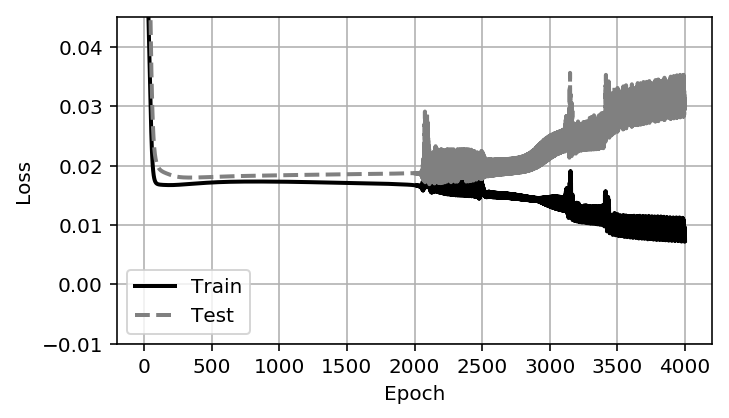

In [7]:
plt.plot(loss_train_history, '-k', label='Train', linewidth=2)
plt.plot(loss_test_history, '--', color='gray', label='Test', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.ylim([-.01, 0.045])
plt.show()

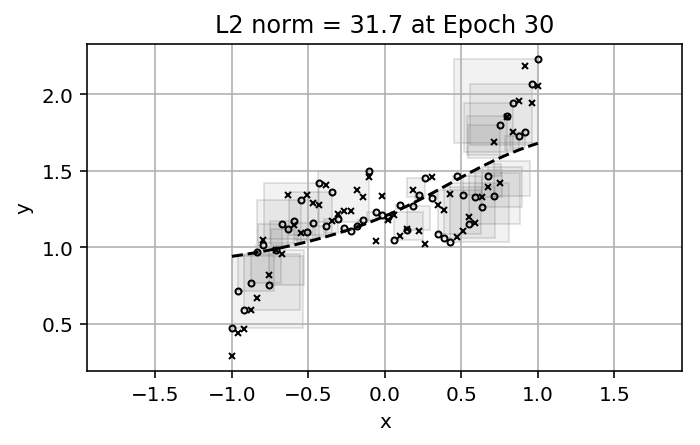

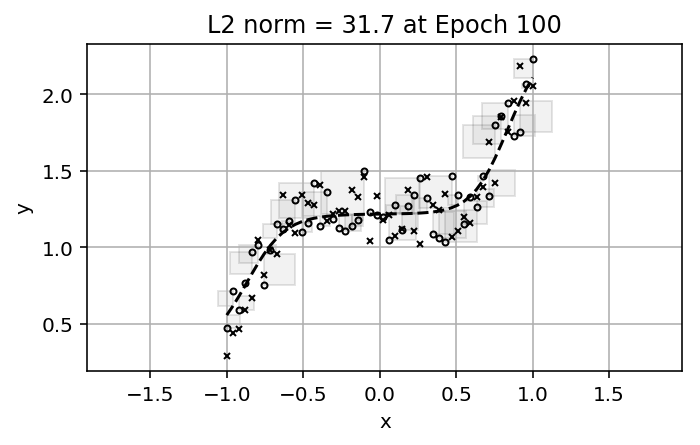

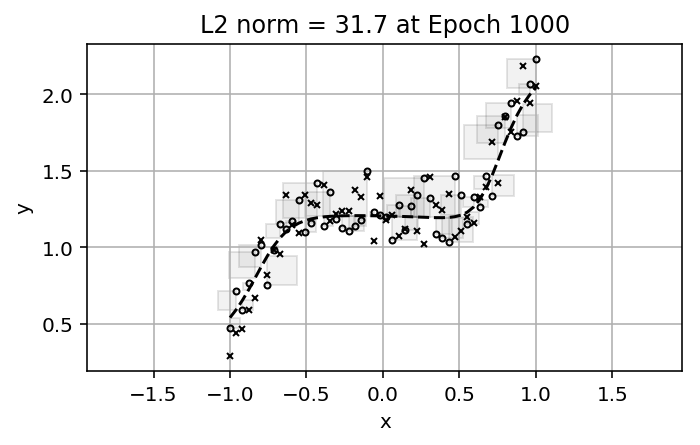

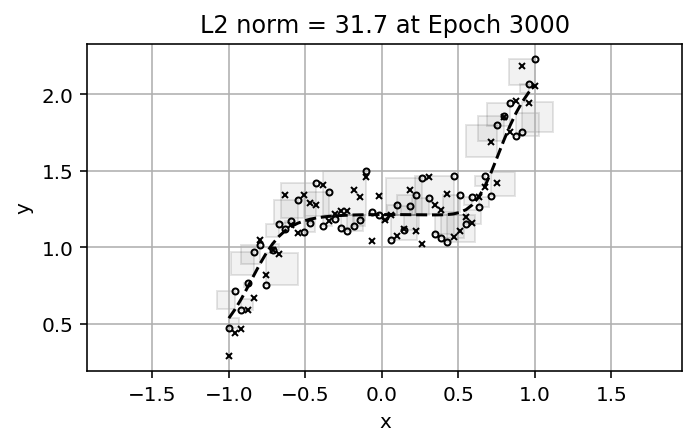

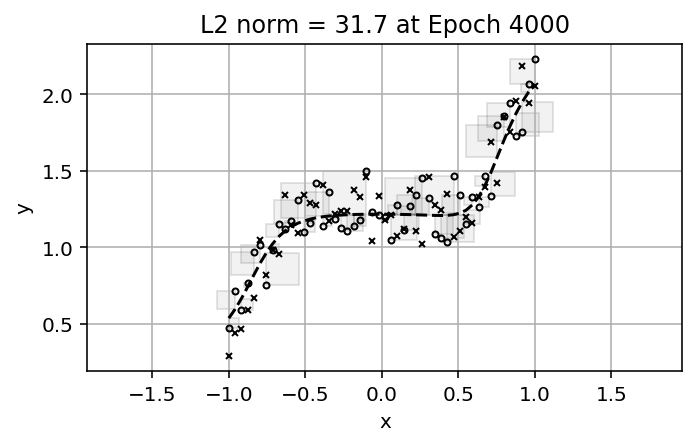

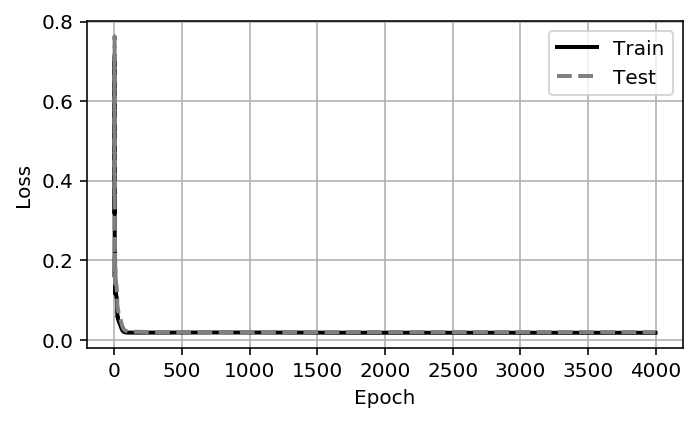

In [8]:
num_hidden1 = 10
num_hidden2 = 5

# 은닉층 1의 Weight
W1 = tf.Variable(tf.random_normal([1, num_hidden1], seed=624))
b1 = tf.Variable(tf.random_normal([num_hidden1], seed=624))

# 은닉층 2의 Weight
W2 = tf.Variable(tf.random_normal([num_hidden1, num_hidden2], seed=624))
b2 = tf.Variable(tf.random_normal([num_hidden2], seed=624))

# 출력층의 Weight
W3 = tf.Variable(tf.random_normal([num_hidden2, 1], seed=624))
b3 = tf.Variable(tf.random_normal([1], seed=624))

# 입력층
x = tf.placeholder(tf.float32, shape=[None, 1])

# 은닉층 1
hidden1 = tf.nn.sigmoid(tf.matmul(x, W1) + b1)

# 은닉층 2
hidden2 = tf.nn.sigmoid(tf.matmul(hidden1, W2) + b2)

# 출력층
yhat = tf.matmul(hidden2, W3) + b3

# 손실함수와 L2 Regularization
beta = 1E-5
y = tf.placeholder(tf.float32, shape=[None, 1])
l2norm = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3)
loss = tf.losses.mean_squared_error(y, yhat) + beta * l2norm

# 수치최적화 알고리즘
MaxEpoch = 4000
lr = 0.1
batch_size = 10
optimizer = tf.train.AdamOptimizer(lr)
train = optimizer.minimize(loss)

# 데이터 섞기
np.random.seed(320)
shuffled_id = np.arange(0, len(x_train))
np.random.shuffle(shuffled_id)
shuffled_x_train = features_train[shuffled_id]
shuffled_y_train = labels_train[shuffled_id]

# 손실함수 기록용 변수
loss_train_history = []
loss_test_history = []

# 스토캐스틱 방법
from helper import generate_batches
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(MaxEpoch+1):
        for x_batch, y_batch in generate_batches(batch_size, 
                                                 shuffled_x_train, 
                                                 shuffled_y_train):
            sess.run(train, feed_dict={x:x_batch, y:y_batch})

        loss_train = sess.run(loss, feed_dict={x:features_train, 
                                               y:labels_train})
        loss_test = sess.run(loss, feed_dict={x:features_test, 
                                              y:labels_test})
        loss_train_history.append(loss_train)
        loss_test_history.append(loss_test)
    
        if epoch in [30, 100, 1000, 3000, 4000]:
            l2_loss_val, pred = sess.run([l2_loss, yhat], 
                                         feed_dict={x:features_train, 
                                                    y:labels_train})
            plt.title("L2 norm = {:1.1f} at Epoch {}".format(l2_loss_val, epoch))
            visualize_l2(pred, x_train, y_train, x_test, y_test)
            plt.show()

plt.plot(loss_train_history, '-k', label='Train'.format(lr), linewidth=2)
plt.plot(loss_test_history, '--', color='gray', label='Test'.format(lr), linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

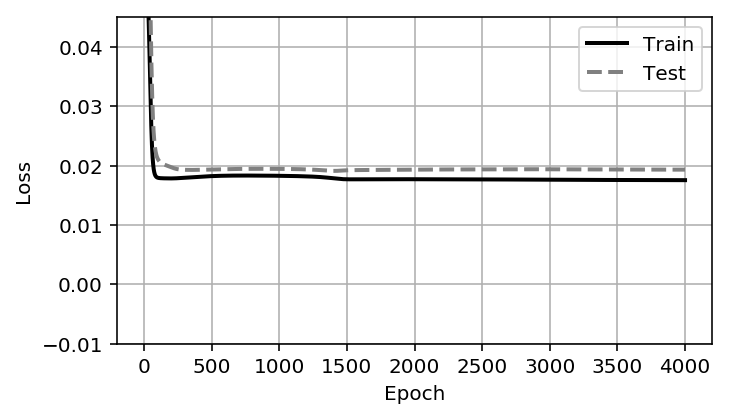

In [9]:
plt.plot(loss_train_history, '-k', label='Train', linewidth=2)
plt.plot(loss_test_history, '--', color='gray', label='Test', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.ylim([-.01, 0.045])
plt.show()

In [10]:
# Regularization에 사용될 상수
beta = 1E-5
l2_reg = tf.contrib.layers.l2_regularizer(beta)

# 입력층
x = tf.placeholder(tf.float32, shape=[None, 1])
rand_init = tf.random_normal_initializer(seed=624)

with tf.variable_scope('TF_API'):
    # 은닉층 1
    hidden1 = tf.contrib.layers.fully_connected(x, num_hidden1,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init,
                                          weights_regularizer=l2_reg)

    # 은닉층 2
    hidden2 = tf.contrib.layers.fully_connected(hidden1, num_hidden2,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init,
                                          weights_regularizer=l2_reg)

    # 출력층
    yhat = tf.contrib.layers.fully_connected(hidden2, 1,
                                          activation_fn=None,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init,
                                          weights_regularizer=l2_reg)

# Regularization Term
reg_ws = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 'TF_API')
print(reg_ws)

[<tf.Tensor 'TF_API/fully_connected/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'TF_API/fully_connected_1/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'TF_API/fully_connected_2/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>]


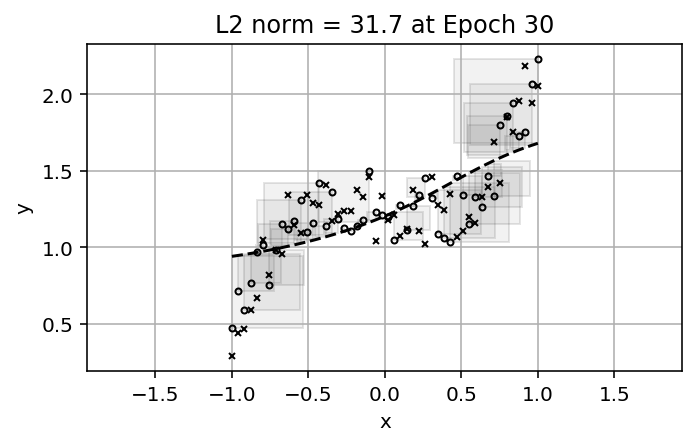

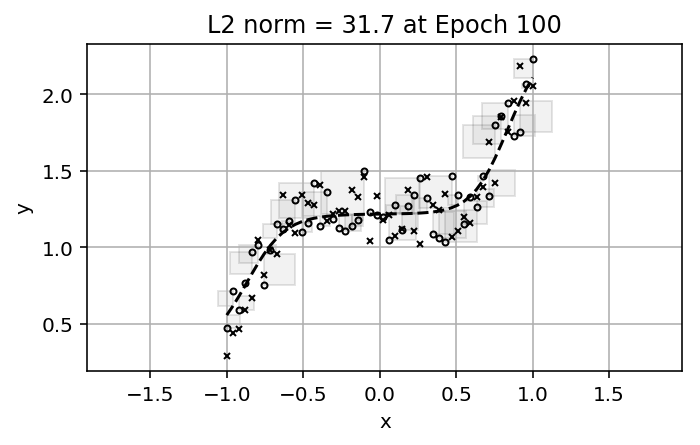

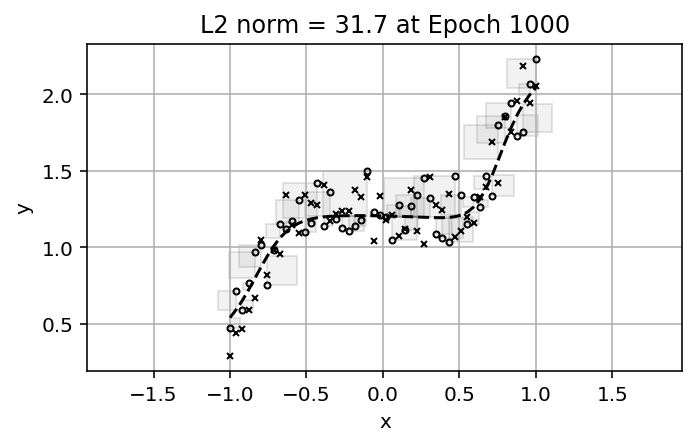

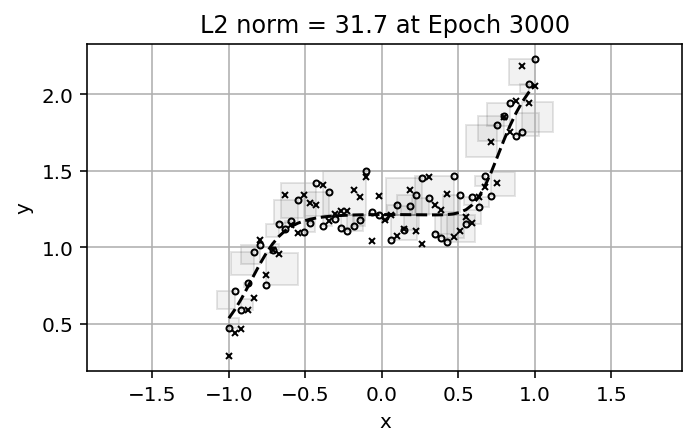

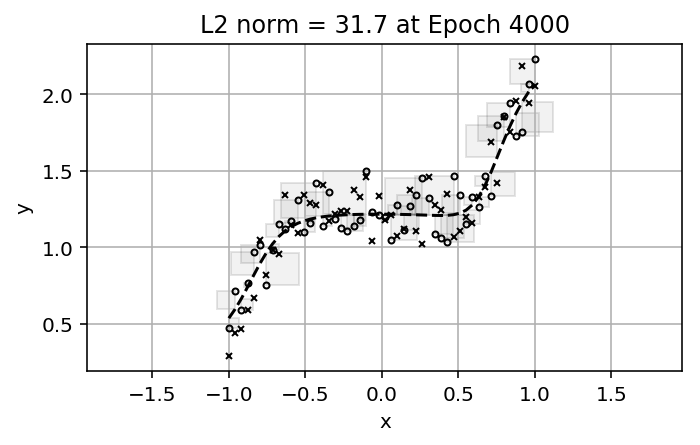

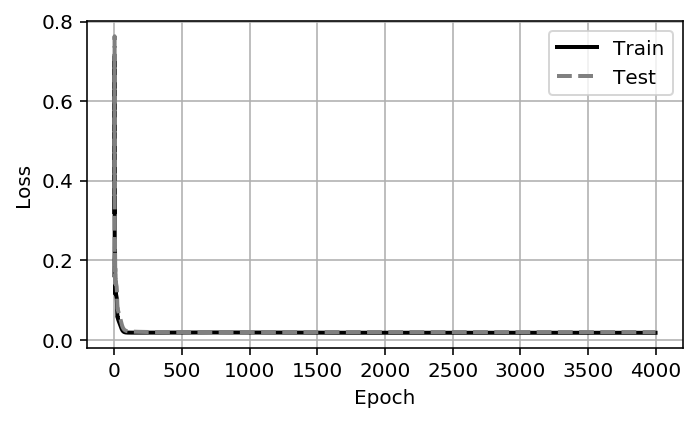

In [12]:
# 손실함수
y = tf.placeholder(tf.float32, shape=[None, 1])
loss = tf.losses.mean_squared_error(y, yhat) + tf.reduce_sum(reg_ws)

# 수치최적화 알고리즘
MaxEpoch = 4000
lr = 0.1
batch_size = 10
optimizer = tf.train.AdamOptimizer(lr)
train = optimizer.minimize(loss)

# 데이터 섞기
np.random.seed(320)
shuffled_id = np.arange(0, len(x_train))
np.random.shuffle(shuffled_id)
shuffled_x_train = features_train[shuffled_id]
shuffled_y_train = labels_train[shuffled_id]

# 손실함수 기록용 변수
loss_train_history = []
loss_test_history = []

# 스토캐스틱 방법
from helper import generate_batches
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(MaxEpoch+1):
        for x_batch, y_batch in generate_batches(batch_size, 
                                                 shuffled_x_train,
                                                 shuffled_y_train):
            sess.run(train, feed_dict={x:x_batch, y:y_batch})

        loss_train = sess.run(loss, feed_dict={x:features_train, 
                                               y:labels_train})
        loss_test = sess.run(loss, feed_dict={x:features_test, 
                                              y:labels_test})
        loss_train_history.append(loss_train)
        loss_test_history.append(loss_test)
        
        if epoch in [30, 100, 1000, 3000, 4000]:
            l2_loss_val, pred = sess.run([l2_loss, yhat], 
                                         feed_dict={x:features_train, 
                                                    y:labels_train})
            plt.title("L2 norm = {:1.1f} at Epoch {}".format(l2_loss_val, epoch))
            visualize_l2(pred, x_train, y_train, x_test, y_test)
            plt.show()

plt.plot(loss_train_history, '-k', label='Train'.format(lr), linewidth=2)
plt.plot(loss_test_history, '--', color='gray', label='Test'.format(lr), linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

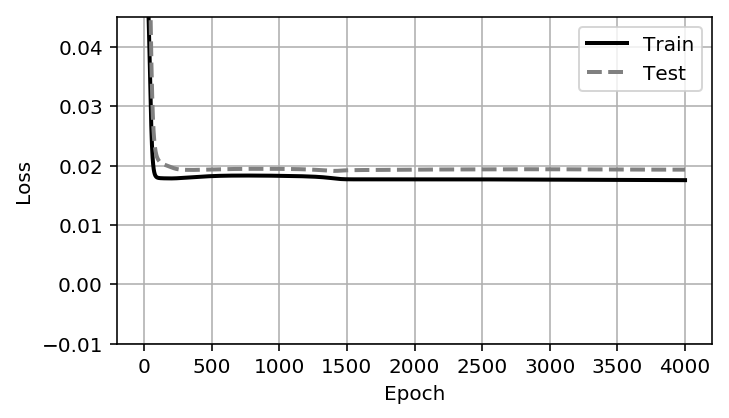

In [13]:
plt.plot(loss_train_history, '-k', label='Train', linewidth=2)
plt.plot(loss_test_history, '--', color='gray', label='Test', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.ylim([-.01, 0.045])
plt.show()

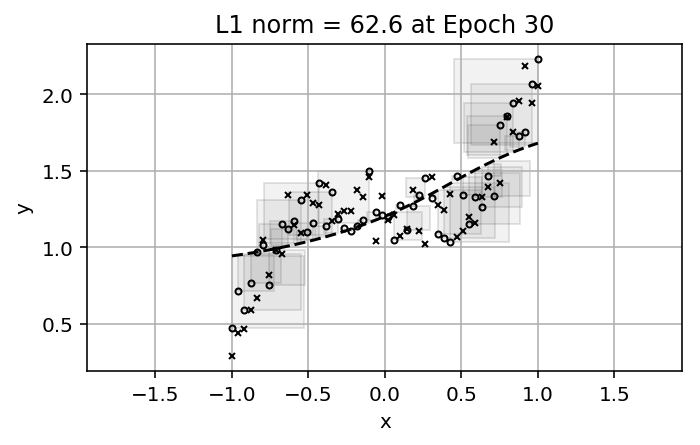

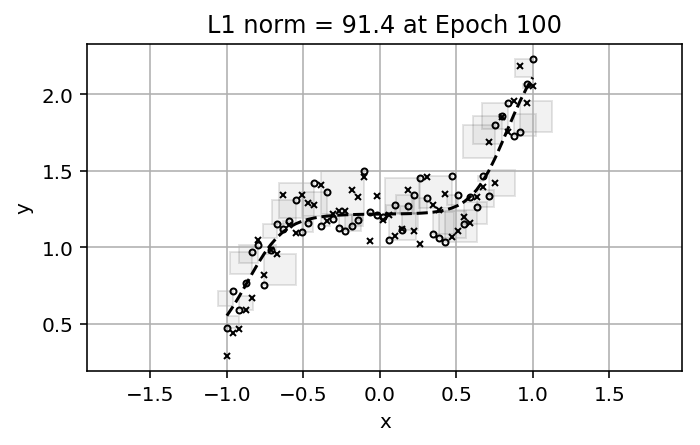

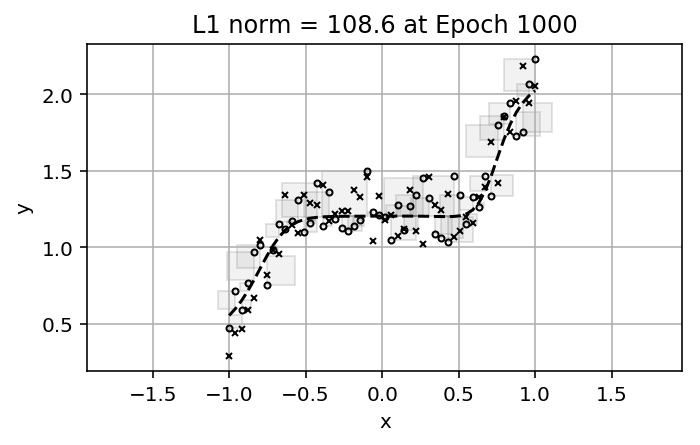

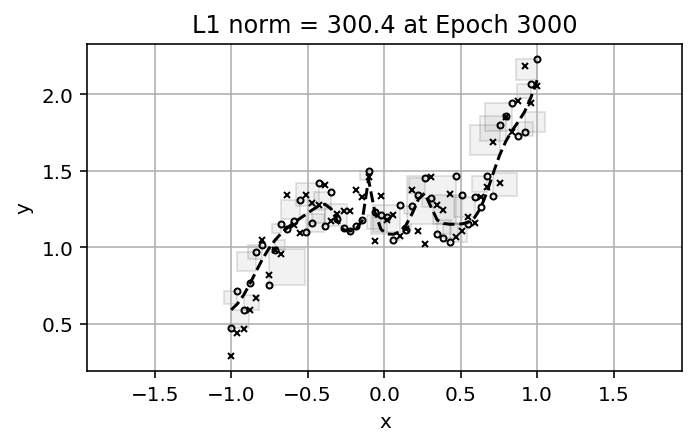

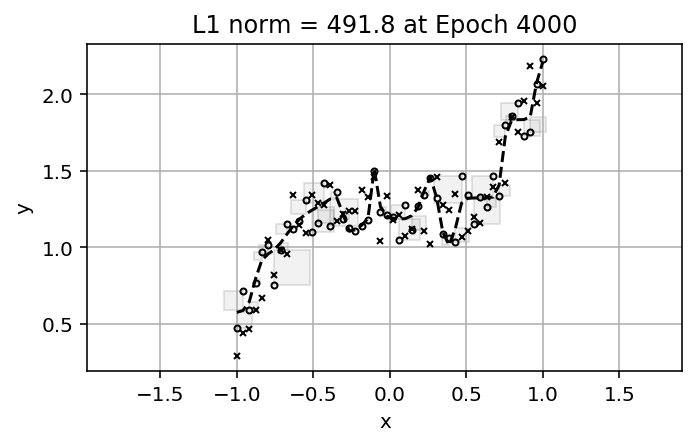

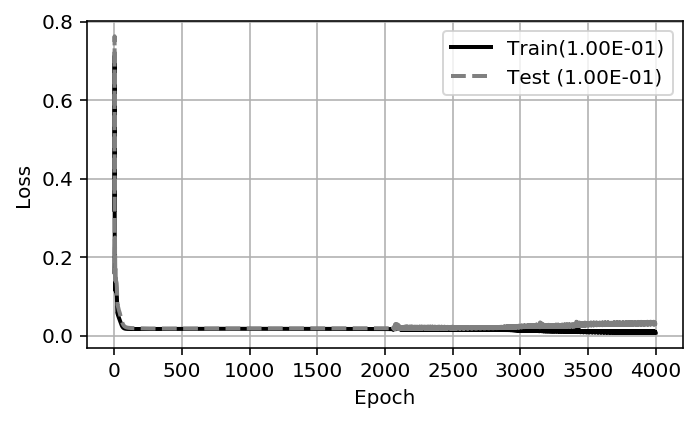

In [14]:
# 데이터 생성
np.random.seed(327)
x_train = np.linspace(-1,1,50)
y_train = x_train**3 + 0.1 * x_train**2 -0.15 * x_train + 1.0 + 0.5 * np.random.rand(len(x_train))

x_test = np.linspace(-1,1,50)
y_test = x_test**3 + 0.1 * x_test**2 -0.15 * x_test + 1.0 + 0.5 * np.random.rand(len(x_test))

features_train = np.array([[xval] for xval in x_train])
labels_train = y_train.reshape(-1, 1)

features_test = np.array([[xval] for xval in x_test])
labels_test = y_test.reshape(-1, 1)

num_hidden1 = 10
num_hidden2 = 5

# 은닉층 1의 Weight
W1 = tf.Variable(tf.random_normal([1, num_hidden1], seed=624))
b1 = tf.Variable(tf.random_normal([num_hidden1], seed=624))

# 은닉층 2의 Weight
W2 = tf.Variable(tf.random_normal([num_hidden1, num_hidden2], seed=624))
b2 = tf.Variable(tf.random_normal([num_hidden2], seed=624))

# 출력층의 Weight
W3 = tf.Variable(tf.random_normal([num_hidden2, 1], seed=624))
b3 = tf.Variable(tf.random_normal([1], seed=624))

# 입력층
x = tf.placeholder(tf.float32, shape=[None, 1])

# 은닉층 1
hidden1 = tf.nn.sigmoid(tf.matmul(x, W1) + b1)

# 은닉층 2
hidden2 = tf.nn.sigmoid(tf.matmul(hidden1, W2) + b2)

# 출력층
yhat = tf.matmul(hidden2, W3) + b3

# 손실함수
y = tf.placeholder(tf.float32, shape=[None, 1])
loss = tf.losses.mean_squared_error(y, yhat)

# Weight l1_loss
l1_loss = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2)) + tf.reduce_sum(tf.abs(W3))

# 수치최적화 알고리즘
MaxEpoch = 4000
lr = 0.1
batch_size = 10
optimizer = tf.train.AdamOptimizer(lr)
train = optimizer.minimize(loss)

# 데이터 섞기
np.random.seed(320)
shuffled_id = np.arange(0, len(x_train))
np.random.shuffle(shuffled_id)
shuffled_x_train = features_train[shuffled_id]
shuffled_y_train = labels_train[shuffled_id]

# 손실함수 기록용 변수
loss_train_history = []
loss_test_history = []

# 스토캐스틱 방법
from helper import generate_batches
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(MaxEpoch+1):
        for x_batch, y_batch in generate_batches(batch_size, 
                                                 shuffled_x_train, 
                                                 shuffled_y_train):
            sess.run(train, feed_dict={x:x_batch, y:y_batch})

        loss_train = sess.run(loss, feed_dict={x:features_train, 
                                               y:labels_train})
        loss_test = sess.run(loss, feed_dict={x:features_test, 
                                              y:labels_test})
        loss_train_history.append(loss_train)
        loss_test_history.append(loss_test)
    
        if epoch in [30, 100, 1000, 3000, 4000]:
            l1_loss_val, pred = sess.run([l1_loss, yhat], 
                                         feed_dict={x:features_train, 
                                                    y:labels_train})
            plt.title("L1 norm = {:1.1f} at Epoch {}".format(l1_loss_val, epoch))
            visualize_l2(pred, x_train, y_train, x_test, y_test)
            plt.show()

plt.plot(loss_train_history, '-k', label='Train({:1.2E})'.format(lr), linewidth=2)
plt.plot(loss_test_history, '--', color='gray', label='Test ({:1.2E})'.format(lr), linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

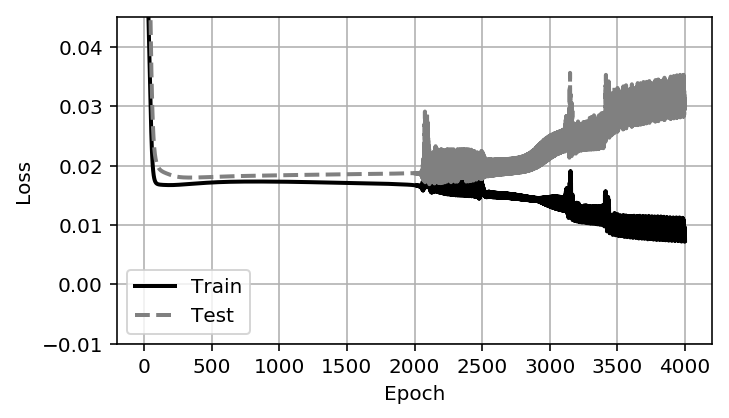

In [15]:
plt.plot(loss_train_history, '-k', label='Train', linewidth=2)
plt.plot(loss_test_history, '--', color='gray', label='Test', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.ylim([-.01, 0.045])
plt.show()

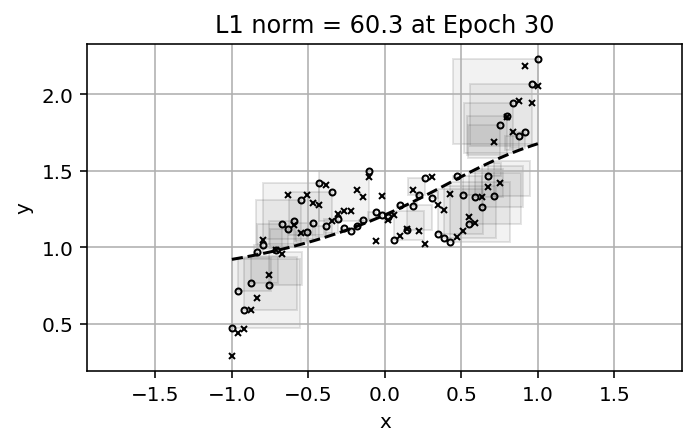

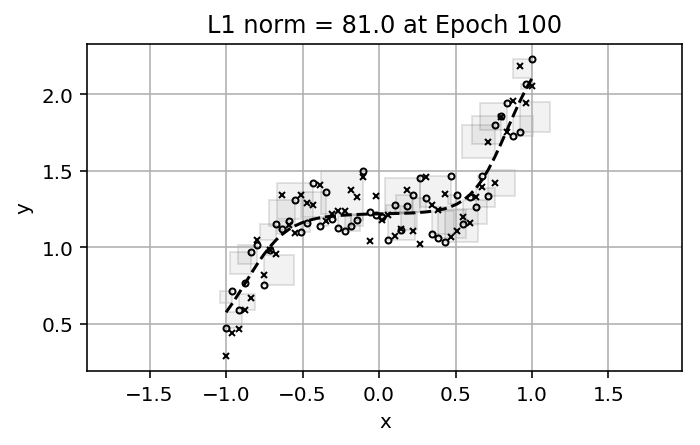

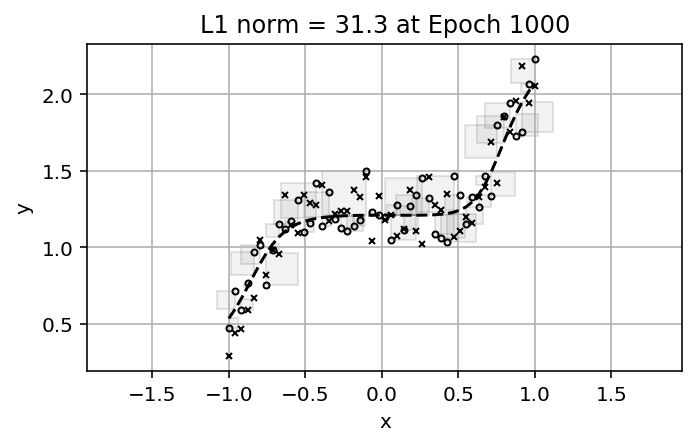

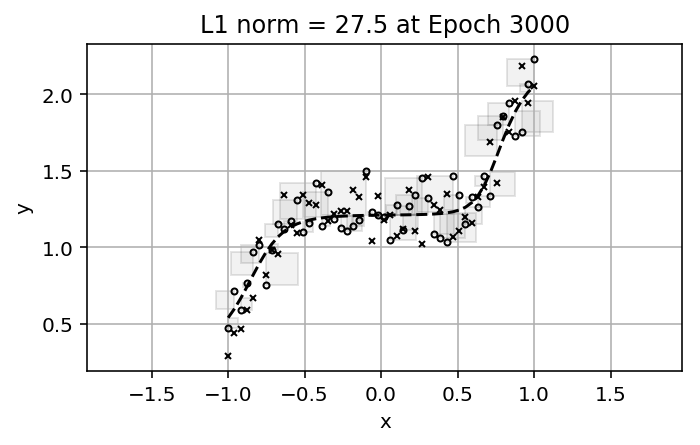

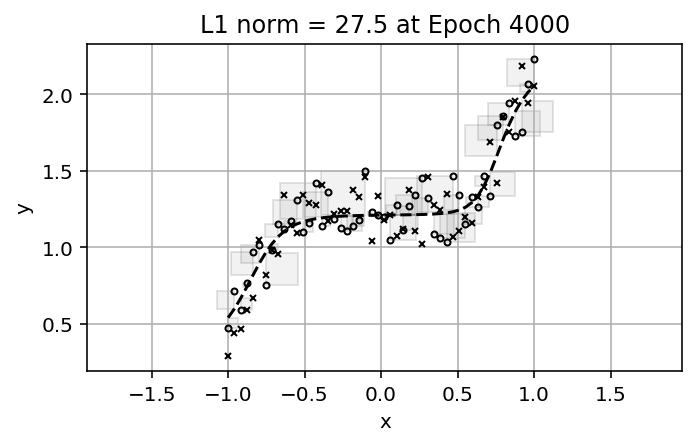

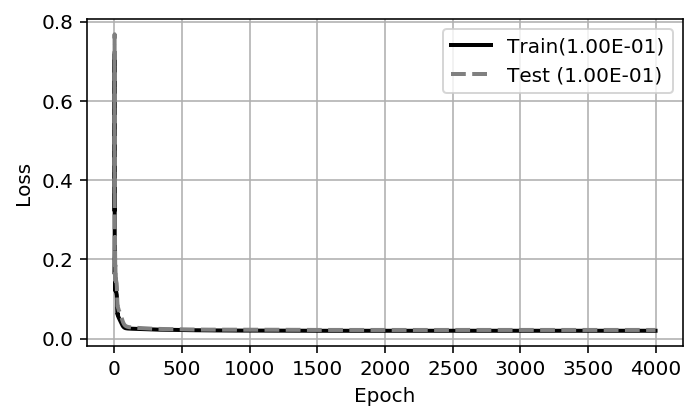

In [16]:
# 은닉층들의 노드 개수
num_hidden1 = 10
num_hidden2 = 5

# 은닉층 1의 Weight
W1 = tf.Variable(tf.random_normal([1, num_hidden1], seed=624))
b1 = tf.Variable(tf.random_normal([num_hidden1], seed=624))

# 은닉층 2의 Weight
W2 = tf.Variable(tf.random_normal([num_hidden1, num_hidden2], seed=624))
b2 = tf.Variable(tf.random_normal([num_hidden2], seed=624))

# 출력층의 Weight
W3 = tf.Variable(tf.random_normal([num_hidden2, 1], seed=624))
b3 = tf.Variable(tf.random_normal([1], seed=624))

# 입력층
x = tf.placeholder(tf.float32, shape=[None, 1])

# 은닉층 1
hidden1 = tf.nn.sigmoid(tf.matmul(x, W1) + b1)

# 은닉층 2
hidden2 = tf.nn.sigmoid(tf.matmul(hidden1, W2) + b2)

# 출력층
yhat = tf.matmul(hidden2, W3) + b3

# L1 Regularization
l1_loss = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2)) + tf.reduce_sum(tf.abs(W3))

# 손실함수
beta = 1E-4
y = tf.placeholder(tf.float32, shape=[None, 1])
loss = tf.losses.mean_squared_error(y, yhat) + beta * l1_loss

# 수치최적화 알고리즘
MaxEpoch = 4000
lr = 0.1
batch_size = 10
optimizer = tf.train.AdamOptimizer(lr)
train = optimizer.minimize(loss)

# 데이터 섞기
np.random.seed(320)
shuffled_id = np.arange(0, len(x_train))
np.random.shuffle(shuffled_id)
shuffled_x_train = features_train[shuffled_id]
shuffled_y_train = labels_train[shuffled_id]

# 손실함수 기록용 변수
loss_train_history = []
loss_test_history = []

# 스토캐스틱 방법
from helper import generate_batches
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(MaxEpoch+1):
        for x_batch, y_batch in generate_batches(batch_size, 
                                                 shuffled_x_train, 
                                                 shuffled_y_train):
            sess.run(train, feed_dict={x:x_batch, y:y_batch})

        loss_train = sess.run(loss, feed_dict={x:features_train, 
                                               y:labels_train})
        loss_test = sess.run(loss, feed_dict={x:features_test, 
                                              y:labels_test})
        loss_train_history.append(loss_train)
        loss_test_history.append(loss_test)
    
        if epoch in [30, 100, 1000, 3000, 4000]:
            l1_loss_val, pred = sess.run([l1_loss, yhat], 
                                         feed_dict={x:features_train, 
                                                    y:labels_train})
            plt.title("L1 norm = {:1.1f} at Epoch {}".format(l1_loss_val, epoch))
            visualize_l2(pred, x_train, y_train, x_test, y_test)
            plt.show()

plt.plot(loss_train_history, '-k', label='Train({:1.2E})'.format(lr), linewidth=2)
plt.plot(loss_test_history, '--', color='gray', label='Test ({:1.2E})'.format(lr), linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

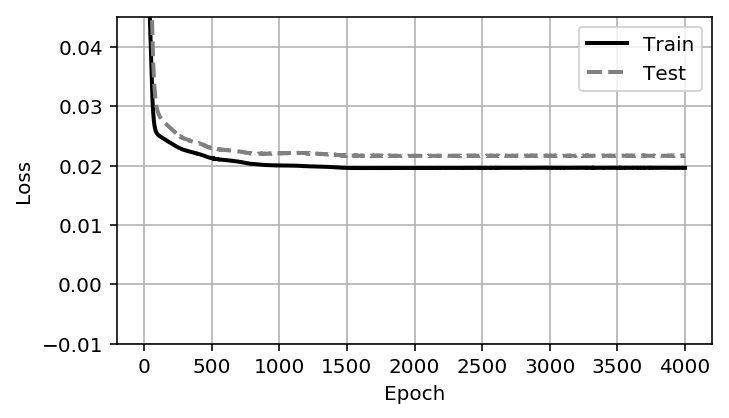

In [17]:
plt.plot(loss_train_history, '-k', label='Train', linewidth=2)
plt.plot(loss_test_history, '--', color='gray', label='Test', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.ylim([-.01, 0.045])
plt.show()

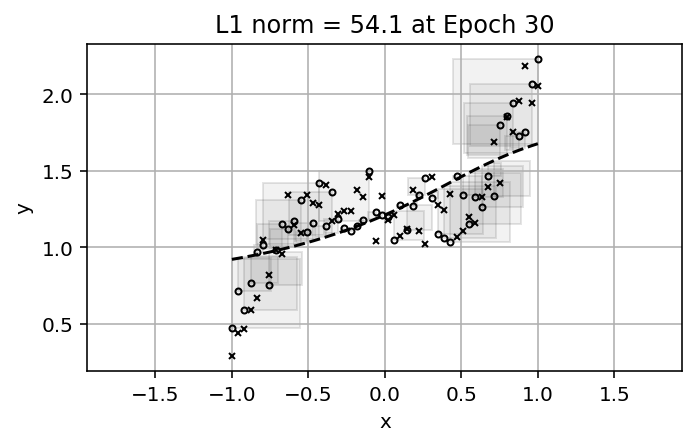

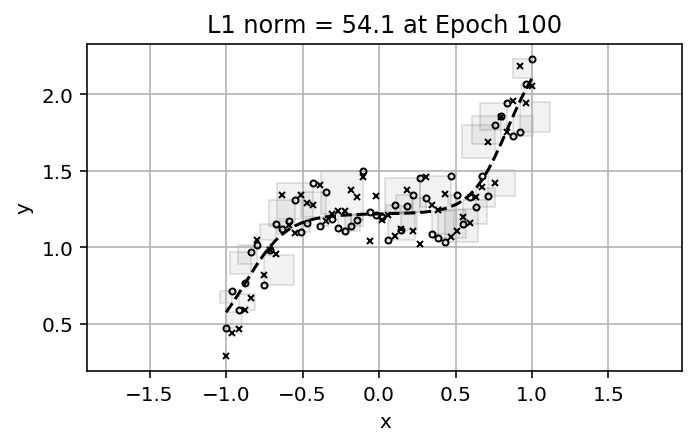

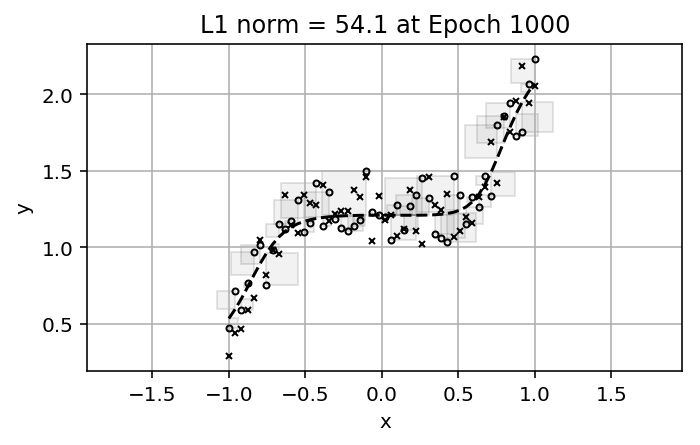

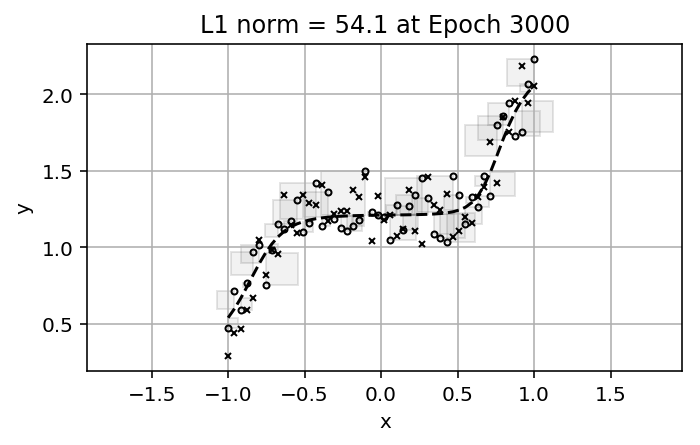

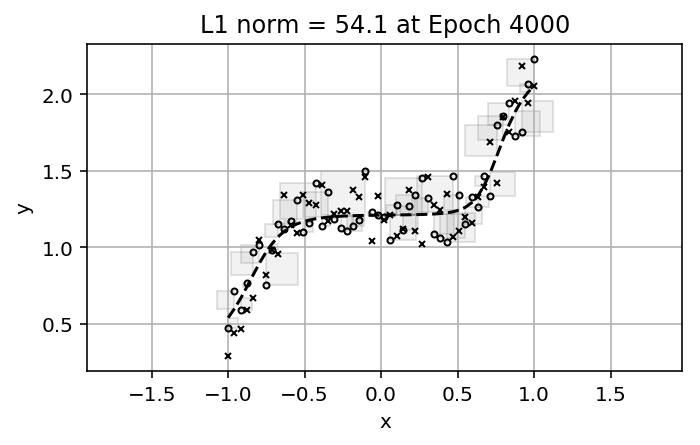

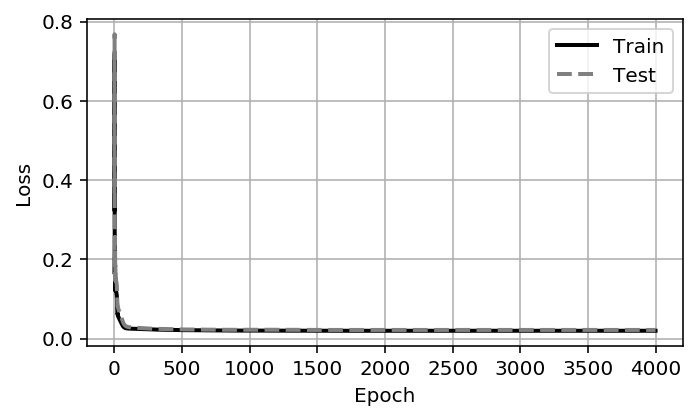

In [18]:
# L1 Regularization 상수
beta = 1E-4
l1_reg = tf.contrib.layers.l1_regularizer(beta)

# 입력층
x = tf.placeholder(tf.float32, shape=[None, 1])
rand_init = tf.random_normal_initializer(seed=624)

with tf.variable_scope('TF_API_L1_REG'):
    # 은닉층 1
    hidden1 =  tf.contrib.layers.fully_connected(x, num_hidden1,
                                              activation_fn=tf.nn.sigmoid,
                                              weights_initializer=rand_init,
                                              biases_initializer=rand_init,
                                              weights_regularizer=l1_reg)

    # 은닉층 2
    hidden2 =  tf.contrib.layers.fully_connected(hidden1, num_hidden2,
                                              activation_fn=tf.nn.sigmoid,
                                              weights_initializer=rand_init,
                                              biases_initializer=rand_init,
                                              weights_regularizer=l1_reg)

    # 출력층
    yhat =  tf.contrib.layers.fully_connected(hidden2, 1,
                                              activation_fn=None,
                                              weights_initializer=rand_init,
                                              biases_initializer=rand_init,
                                              weights_regularizer=l1_reg)

# Regularization Term
reg_ws = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 'TF_API_L1_REG')

# 손실함수
y = tf.placeholder(tf.float32, shape=[None, 1])
loss = tf.losses.mean_squared_error(y, yhat) + tf.reduce_sum(reg_ws)

# 수치최적화 알고리즘
MaxEpoch = 4000
lr = 0.1
batch_size = 10
optimizer = tf.train.AdamOptimizer(lr)
train = optimizer.minimize(loss)

# 데이터 섞기
np.random.seed(320)
shuffled_id = np.arange(0, len(x_train))
np.random.shuffle(shuffled_id)
shuffled_x_train = features_train[shuffled_id]
shuffled_y_train = labels_train[shuffled_id]

# 손실함수 기록용 변수
loss_train_history = []
loss_test_history = []

# 스토캐스틱 방법
from helper import generate_batches
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(MaxEpoch+1):
        for x_batch, y_batch in generate_batches(batch_size, 
                                                 shuffled_x_train,
                                                 shuffled_y_train):
            sess.run(train, feed_dict={x:x_batch, y:y_batch})

        loss_train = sess.run(loss, feed_dict={x:features_train, 
                                               y:labels_train})
        loss_test = sess.run(loss, feed_dict={x:features_test, 
                                              y:labels_test})
        loss_train_history.append(loss_train)
        loss_test_history.append(loss_test)
        
        if epoch in [30, 100, 1000, 3000, 4000]:
            l1_loss_val, pred = sess.run([l1_loss, yhat], 
                                         feed_dict={x:features_train, 
                                                    y:labels_train})
            plt.title("L1 norm = {:1.1f} at Epoch {}".format(l1_loss_val, epoch))
            visualize_l2(pred, x_train, y_train, x_test, y_test)
            plt.show()

plt.plot(loss_train_history, '-k', label='Train'.format(lr), linewidth=2)
plt.plot(loss_test_history, '--', color='gray', label='Test'.format(lr), linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

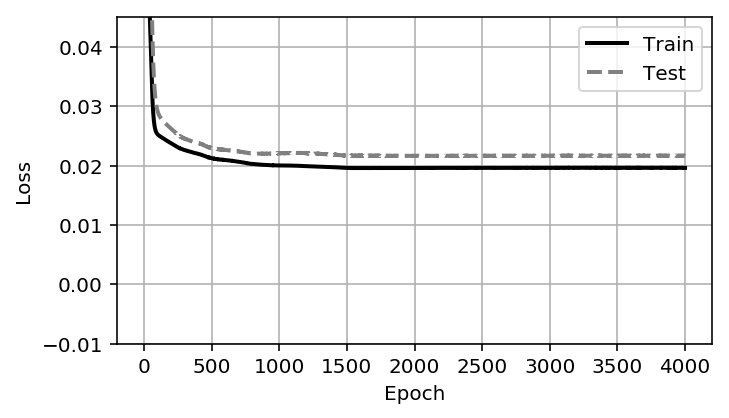

In [19]:
plt.plot(loss_train_history, '-k', label='Train', linewidth=2)
plt.plot(loss_test_history, '--', color='gray', label='Test', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.ylim([-.01, 0.045])
plt.show()

In [20]:
x = tf.placeholder(tf.float32)
dropout_operation = tf.contrib.layers.dropout(x, keep_prob=0.5)
with tf.Session() as sess:
    out = sess.run(dropout_operation, 
                   feed_dict={x:[1,2,3,4,5,6,7,8,9,10]})
    print(out)

[ 2.  4.  6.  0. 10. 12.  0. 16. 18. 20.]


In [21]:
dropout_operation = tf.contrib.layers.dropout(x, keep_prob=0.1)
with tf.Session() as sess:
    out = sess.run(dropout_operation, 
                   feed_dict={x:[1,2,3,4,5,6,7,8,9,10]})
    print(out)

[ 0. 20.  0.  0.  0.  0.  0.  0.  0.  0.]


In [22]:
dropout_operation = tf.contrib.layers.dropout(x, keep_prob=1)
with tf.Session() as sess:
    out = sess.run(dropout_operation, 
                   feed_dict={x:[1,2,3,4,5,6,7,8,9,10]})
    print(out)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


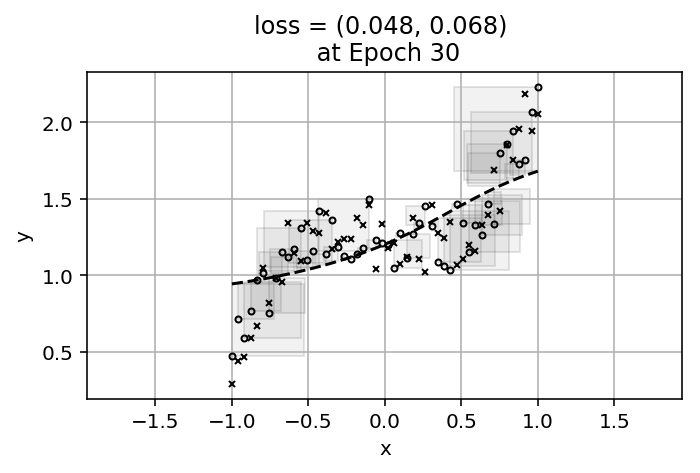

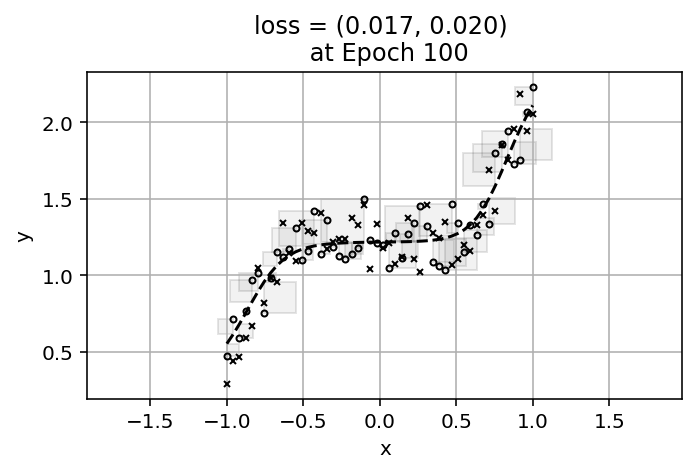

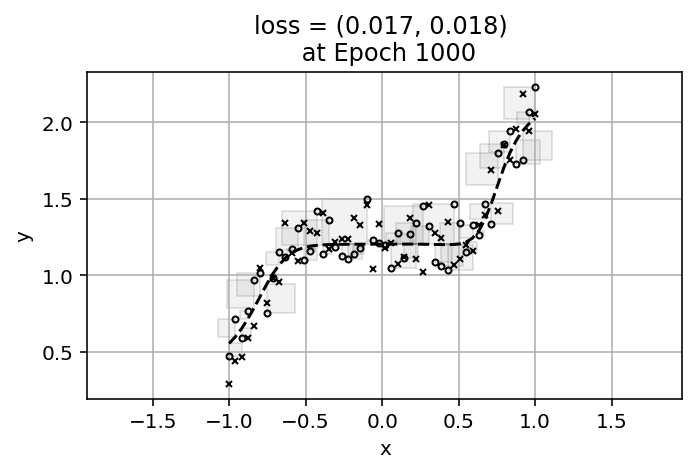

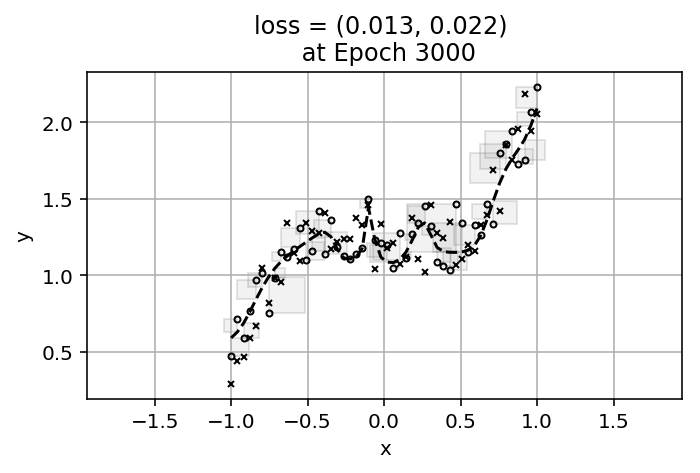

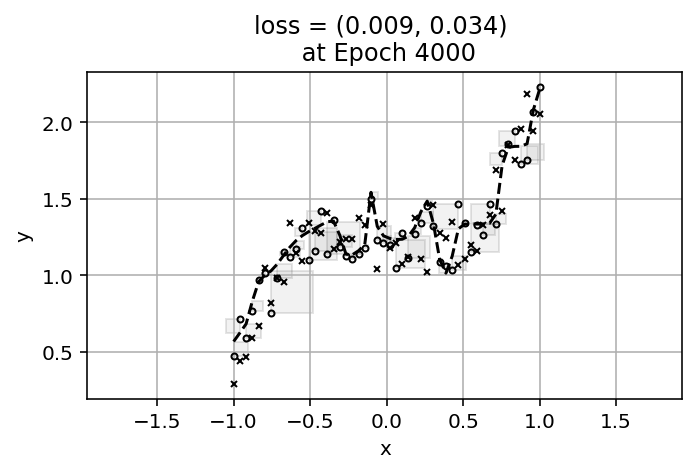

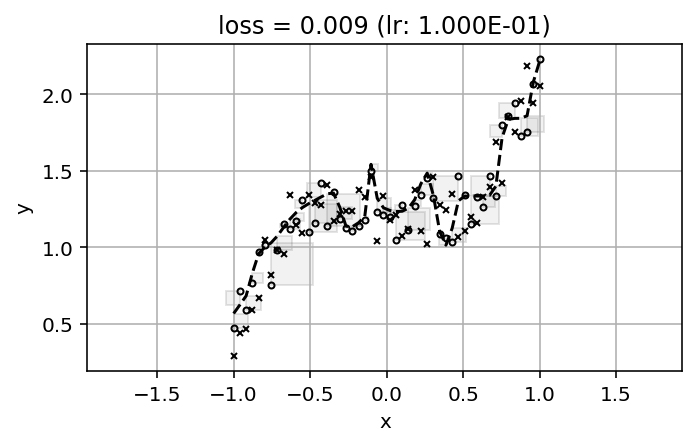

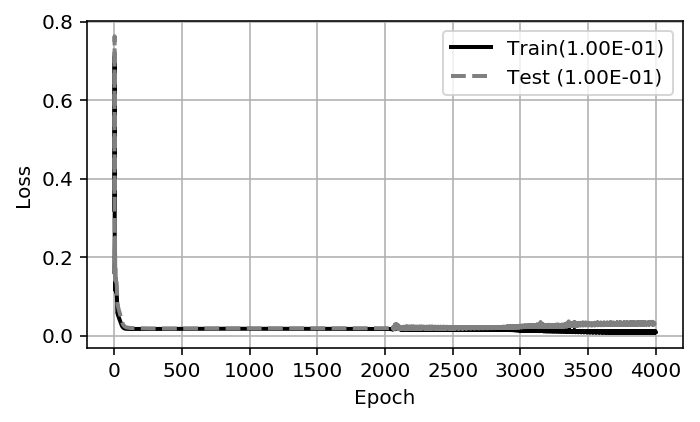

In [23]:
# 은닉층들의 노드 개수
num_hidden1 = 10
num_hidden2 = 5
rand_init = tf.random_normal_initializer(seed=624)

# 입력층
x = tf.placeholder(tf.float32, shape=[None, 1])

# 은닉층 1
hidden1 =  tf.contrib.layers.fully_connected(x, num_hidden1,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init)

# 은닉층 2
hidden2 =  tf.contrib.layers.fully_connected(hidden1, num_hidden2,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init)

# 출력층
yhat =  tf.contrib.layers.fully_connected(hidden2, 1,
                                          activation_fn=None,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init)

# 손실함수
y = tf.placeholder(tf.float32, shape=[None, 1])
loss = tf.losses.mean_squared_error(y, yhat)

# 수치최적화 알고리즘
MaxEpoch = 4000
lr = 0.1
batch_size = 10
optimizer = tf.train.AdamOptimizer(lr)
train = optimizer.minimize(loss)

# 데이터 섞기
np.random.seed(320)
shuffled_id = np.arange(0, len(x_train))
np.random.shuffle(shuffled_id)
shuffled_x_train = features_train[shuffled_id]
shuffled_y_train = labels_train[shuffled_id]

# 손실함수 기록용 변수
loss_train_history = []
loss_test_history = []

# 스토캐스틱 방법
from helper import generate_batches
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(MaxEpoch+1):
        for x_batch, y_batch in generate_batches(batch_size, 
                                                 shuffled_x_train, 
                                                 shuffled_y_train):
            sess.run(train, feed_dict={x:x_batch, y:y_batch})

        loss_train = sess.run(loss, feed_dict={x:features_train, 
                                               y:labels_train})
        loss_test = sess.run(loss, feed_dict={x:features_test, 
                                              y:labels_test})
        loss_train_history.append(loss_train)
        loss_test_history.append(loss_test)
    
        if epoch in [30, 100, 1000, 3000, 4000]:
            loss_val_train, pred = sess.run([loss, yhat], 
                                            feed_dict={x:features_train, 
                                                       y:labels_train})
            loss_val_test, pred = sess.run([loss, yhat], 
                                           feed_dict={x:features_test, 
                                                      y:labels_test})
            plt.title("loss = ({:1.3f}, {:1.3f}) \n at Epoch {}".format(loss_val_train, loss_val_test, epoch))
            visualize_l2(pred, x_train, y_train, x_test, y_test)
            plt.show()
    
    final_loss, pred = sess.run([loss, yhat], feed_dict={x:features_train, y:labels_train})

plt.title("loss = {:1.3f} (lr: {:1.3E})".format(final_loss, lr))
visualize_l2(pred, x_train, y_train, x_test, y_test)
plt.show()

plt.plot(loss_train_history, '-k', label='Train({:1.2E})'.format(lr), linewidth=2)
plt.plot(loss_test_history, '--', color='gray', label='Test ({:1.2E})'.format(lr), linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

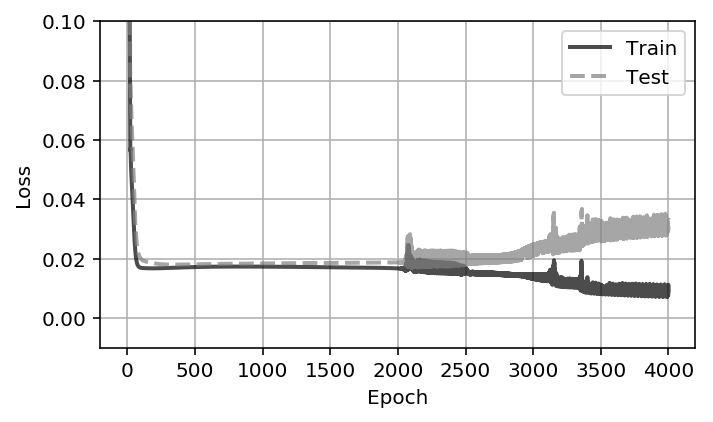

In [24]:
plt.plot(loss_train_history, '-k', label='Train', linewidth=2, alpha=0.7)
plt.plot(loss_test_history, '--', color='gray', label='Test', linewidth=2, alpha=0.7)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.ylim([-.01, 0.10])
plt.show()

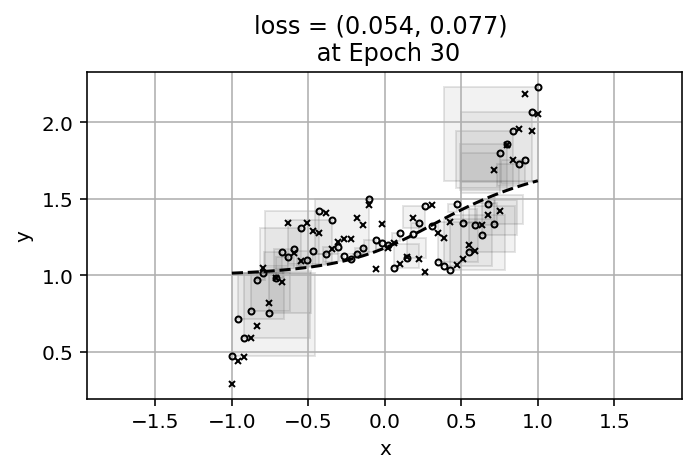

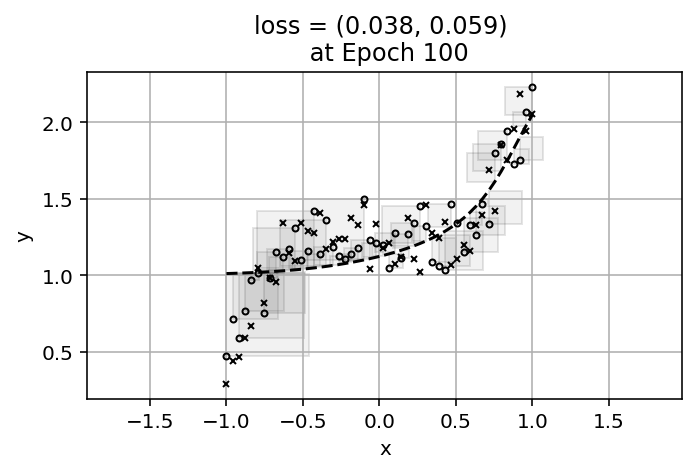

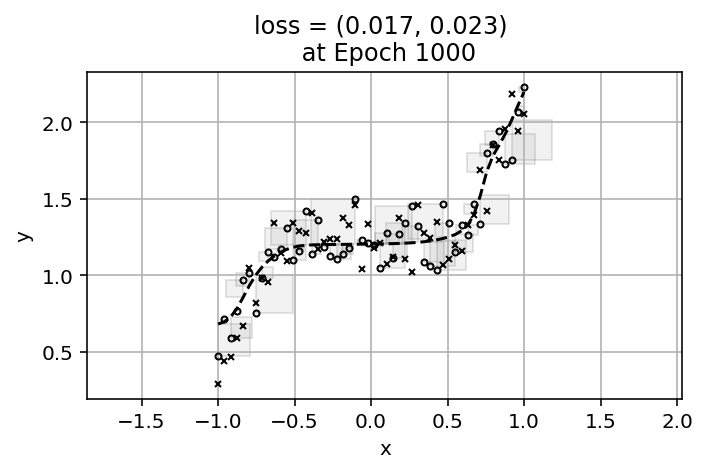

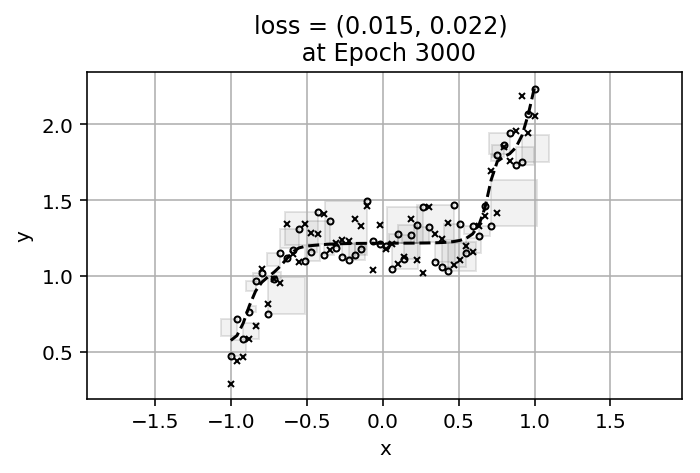

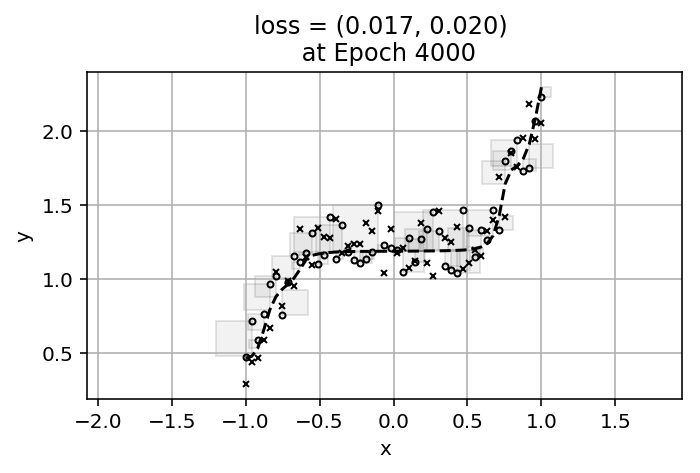

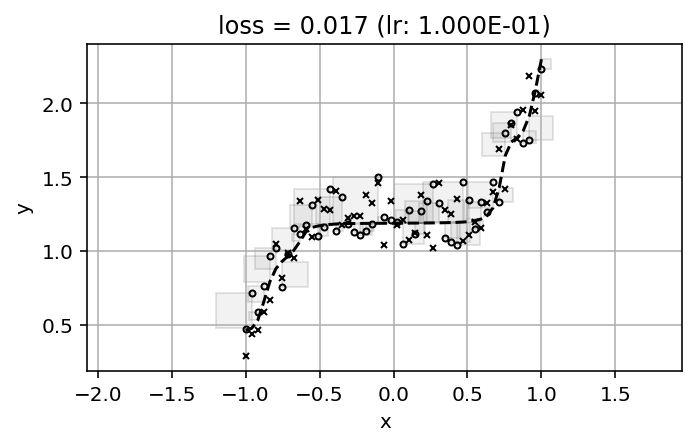

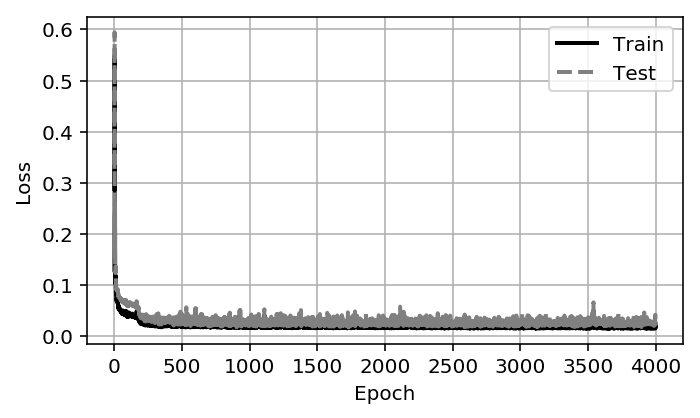

In [25]:
keep_probability = tf.placeholder(tf.float32)
num_hidden1 = 10
num_hidden2 = 5
rand_init = tf.random_normal_initializer(seed=624)

# 입력층
x = tf.placeholder(tf.float32, shape=[None, 1])

# 은닉층 1
hidden1 =  tf.contrib.layers.fully_connected(x, num_hidden1,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init)
# 드랍아웃 1
hidden1 = tf.contrib.layers.dropout(hidden1, keep_prob=keep_probability, 
                                    seed=848)

# 은닉층 2
hidden2 =  tf.contrib.layers.fully_connected(hidden1, num_hidden2,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init)
# 드랍아웃 2
hidden2 = tf.contrib.layers.dropout(hidden2, keep_prob=keep_probability, 
                                    seed=848)


# 출력층
yhat =  tf.contrib.layers.fully_connected(hidden2, 1,
                                          activation_fn=None,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init)



# 손실함수
y = tf.placeholder(tf.float32, shape=[None, 1])
loss = tf.losses.mean_squared_error(y, yhat)

# 수치최적화 알고리즘
MaxEpoch = 4000
lr = 0.1
batch_size = 10
optimizer = tf.train.AdamOptimizer(lr)
train = optimizer.minimize(loss)

# 데이터 섞기
np.random.seed(320)
shuffled_id = np.arange(0, len(x_train))
np.random.shuffle(shuffled_id)
shuffled_x_train = features_train[shuffled_id]
shuffled_y_train = labels_train[shuffled_id]

# 손실함수 기록용 변수
loss_train_history = []
loss_test_history = []

# 스토캐스틱 방법
from helper import generate_batches
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(MaxEpoch+1):
        for x_batch, y_batch in generate_batches(batch_size, 
                                                 shuffled_x_train,
                                                 shuffled_y_train):
            sess.run(train, feed_dict={x:x_batch, 
                                       y:y_batch, 
                                       keep_probability: 0.85})

        loss_train = sess.run(loss, feed_dict={x:features_train, 
                                               y:labels_train, 
                                               keep_probability: 1.0})
        loss_test = sess.run(loss, feed_dict={x:features_test,
                                              y:labels_test,
                                              keep_probability: 1.0})
        loss_train_history.append(loss_train)
        loss_test_history.append(loss_test)
    
        if epoch in [30, 100, 1000, 3000, 4000]:
            loss_val_train, pred = sess.run([loss, yhat], feed_dict={x:features_train, y:labels_train, keep_probability: 1.0})
            loss_val_test, pred = sess.run([loss, yhat], feed_dict={x:features_test, y:labels_test, keep_probability: 1.0})
            plt.title("loss = ({:1.3f}, {:1.3f}) \n at Epoch {}".format(loss_val_train, loss_val_test, epoch))
            visualize_l2(pred, x_train, y_train, x_test, y_test)
            plt.show()
    
    final_loss, pred = sess.run([loss, yhat], feed_dict={x:features_train, y:labels_train, keep_probability: 1.0})

plt.title("loss = {:1.3f} (lr: {:1.3E})".format(final_loss, lr))
visualize_l2(pred, x_train, y_train, x_test, y_test)
plt.show()

plt.plot(loss_train_history, '-k', label='Train', linewidth=2)
plt.plot(loss_test_history, '--', color='gray', label='Test', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

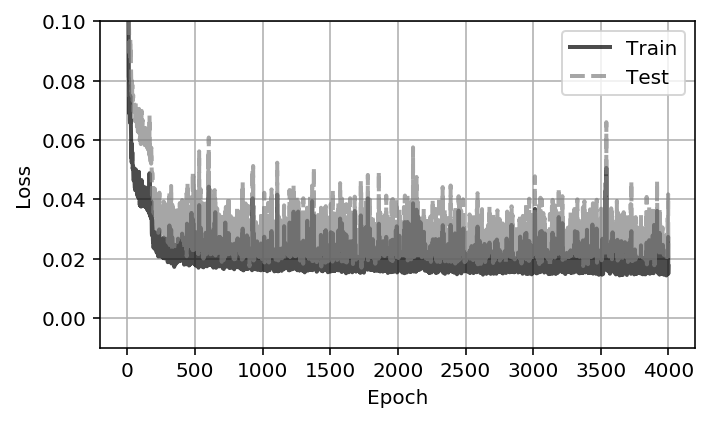

In [26]:
plt.plot(loss_train_history, '-k', label='Train', linewidth=2, alpha=0.7)
plt.plot(loss_test_history, '--', color='gray', label='Test', linewidth=2, alpha=0.7)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.ylim([-.01, 0.10])
plt.show()

In [27]:
plt.rcParams['figure.figsize'] = (16./3, 9./3)

def plot_model(sess, model, xy, labels, xy_test, labels_test, feature_lambda, title=''):
    from pandas import DataFrame
    xx, yy = np.meshgrid(np.linspace(-1.2,1.2,400), np.linspace(-1.2,1.2,400))
    prediction = sess.run(model, feed_dict={x: np.array([feature_lambda(xxval, yyval) for xxval, yyval in zip(xx.flatten(), yy.flatten())])})
    Z = prediction.reshape(xx.shape)
    df = DataFrame(dict(x=xy[:,0], y=xy[:,1], label=labels.flatten()))
    markers = {0:'bs', 1:'r^'}
    _, ax = plt.subplots(figsize=(5, 5))
    predictions = sess.run(model, feed_dict={x: xy})
    for k, xy0 in df[['x', 'y']].iterrows():
        x0, y0 = xy0.values
        plt.plot(x0, y0, markers[labels[k][0]], mec='k')
        
    df = DataFrame(dict(x=xy_test[:,0], y=xy_test[:,1], label=labels_test.flatten()))
    markers = {0:'bs', 1:'r^'}
    cs = ax.contourf(xx, yy, Z, 20, cmap='coolwarm', alpha=.9)
    ax.clabel(cs, colors='gray')
    cs = ax.contour(xx, yy, Z, cmap='gray', levels=[0, 0.5, 1.0], linestyles='--', linewidths=2)
    ax.clabel(cs, colors='k')
    predictions = sess.run(model, feed_dict={x: xy})
    for k, xy0 in df[['x', 'y']].iterrows():
        x0, y0 = xy0.values
        plt.plot(x0, y0, markers[labels[k][0]], mec='none')
        
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    plt.grid(linestyle='--', alpha=0.5)
    plt.title(title)
    plt.show()

In [28]:
from sklearn.datasets import make_circles

# 학습용 데이터 생성
xy_train, labels_train = make_circles(n_samples=50, noise=0.1,
                                      random_state=717)
labels_train = labels_train.reshape(-1,1)

# 테스트용 데이터 생성
xy_test, labels_test = make_circles(n_samples=50, noise=0.1,
                                    random_state=712)
labels_test = labels_test.reshape(-1,1)

In [29]:
# 특성값 추출
f_fn = lambda x,y: [x, y]
features = np.array([f_fn(xval, yval) for xval, yval in xy_train])
features_test = np.array([f_fn(xval, yval) for xval, yval in xy_test])
dim_features = features.shape[1]

# 예측모델
num_hidden1 = 10
num_hidden2 = 5
rand_init = tf.random_normal_initializer(seed=624)

# 입력층
x = tf.placeholder(tf.float32, shape=(None, dim_features))

# 은닉층 1
hidden1 =  tf.contrib.layers.fully_connected(x, num_hidden1,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init)

# 은닉층 2
hidden2 =  tf.contrib.layers.fully_connected(hidden1, num_hidden2,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init)

# 출력층
yhat =  tf.contrib.layers.fully_connected(hidden2, 1,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init)

# 손실함수
y = tf.placeholder(tf.float32, shape=(None, 1))
loss = tf.reduce_mean(-y * tf.log(yhat) - (1-y) * tf.log(1-yhat))

# 정확도
correct_prediction = tf.equal(y, tf.round(yhat))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

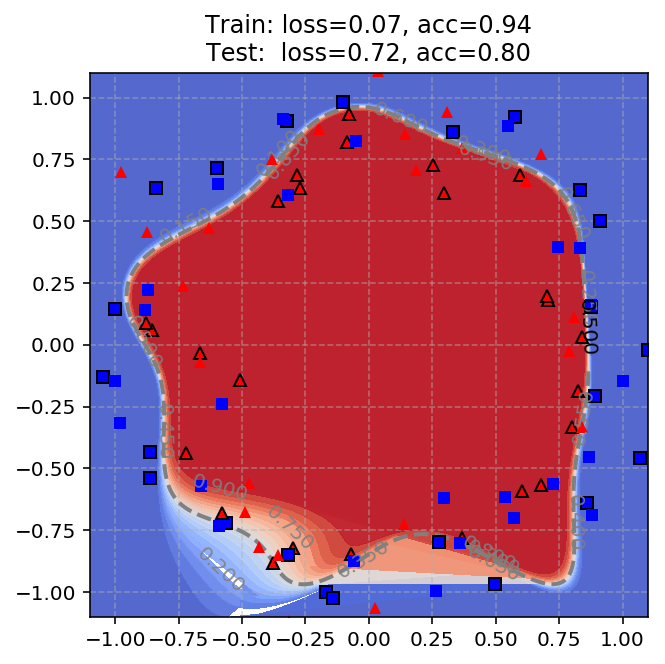

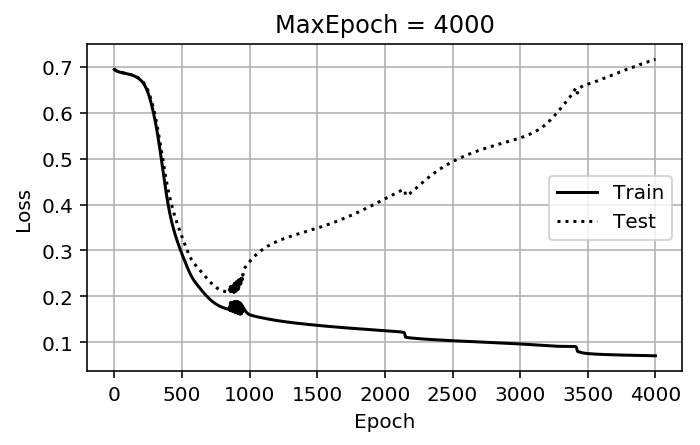

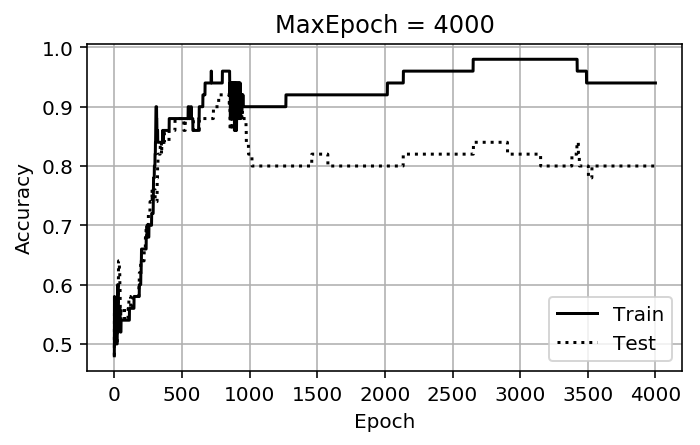

In [30]:
# 수치최적화 알고리즘
lr = 0.5
optimizer = tf.train.GradientDescentOptimizer(lr)
train = optimizer.minimize(loss)

# 손실함수 및 정확도 기록
loss_train_history = []
loss_test_history = []
acc_train_history = []
acc_test_history = []

from helper import generate_batches
# 데이터 섞기
np.random.seed(7382)
idx = np.arange(0, len(features))
np.random.shuffle(idx)
shuffled_features = features[idx]
shuffled_labels = labels_train[idx]

# 스토캐스틱 방법
MaxEpochs = 4000
batch_size = 10
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
for epoch in range(MaxEpochs+1):
    for x_batch, y_batch in generate_batches(batch_size, 
                                             shuffled_features, 
                                             shuffled_labels):
        sess.run(train, feed_dict={x: x_batch, y: y_batch})
    loss_val_train, acc_train = sess.run([loss, accuracy], 
                                         feed_dict={x: features, 
                                                    y: labels_train})
    loss_val_test, acc_test = sess.run([loss, accuracy], 
                                       feed_dict={x: features_test, 
                                                  y: labels_test})

    loss_train_history.append(loss_val_train)
    acc_train_history.append(acc_train)
    loss_test_history.append(loss_val_test)
    acc_test_history.append(acc_test)

plot_model(sess, yhat, xy_train, labels_train, xy_test, labels_test, f_fn, \
       'Train: loss={:1.2f}, acc={:1.2f}\nTest:  loss={:1.2f}, acc={:1.2f}'\
       .format(loss_val_train, acc_train, loss_val_test, acc_test))


plt.plot(loss_train_history, '-k', label='Train')
plt.plot(loss_test_history, ':k', label='Test')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MaxEpoch = {}'.format(MaxEpochs))
plt.legend()
plt.show()

plt.plot(acc_train_history, '-k', label='Train')
plt.plot(acc_test_history, ':k', label='Test')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MaxEpoch = {}'.format(MaxEpochs))
plt.legend()
plt.show()

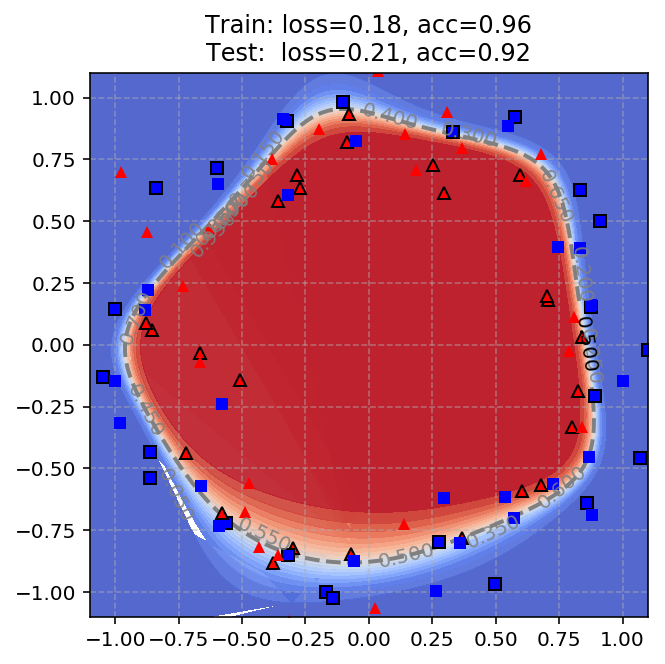

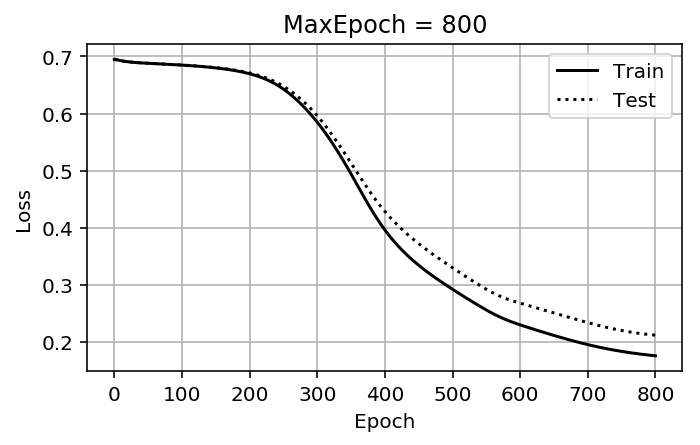

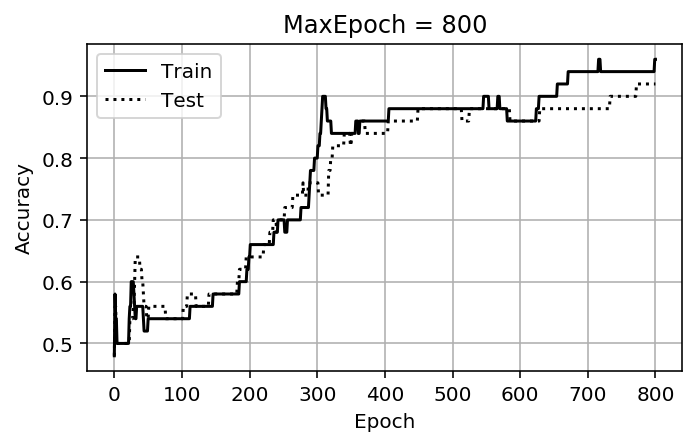

In [31]:
# 특성값 추출
features = np.array([f_fn(xval, yval) for xval, yval in xy_train])
features_test = np.array([f_fn(xval, yval) for xval, yval in xy_test])
dim_features = features.shape[1]

# 예측모델
num_hidden1 = 10
num_hidden2 = 5

# 입력층
x = tf.placeholder(tf.float32, shape=(None, dim_features))
rand_init = tf.random_normal_initializer(seed=624)

# 은닉층 1
hidden1 =  tf.contrib.layers.fully_connected(x, num_hidden1,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init)

# 은닉층 2
hidden2 =  tf.contrib.layers.fully_connected(hidden1, num_hidden2,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init)

# 출력층
yhat =  tf.contrib.layers.fully_connected(hidden2, 1,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init)
# 손실함수
y = tf.placeholder(tf.float32, shape=(None, 1))
loss = tf.reduce_mean(-y * tf.log(yhat) - (1-y) * tf.log(1-yhat))

# 정확도
correct_prediction = tf.equal(y, tf.round(yhat))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 수치최적화 알고리즘
lr = 0.5
optimizer = tf.train.GradientDescentOptimizer(lr)
train = optimizer.minimize(loss)

from helper import generate_batches
# 데이터 섞기
np.random.seed(7382)
idx = np.arange(0, len(features))
np.random.shuffle(idx)
shuffled_features = features[idx]
shuffled_labels = labels_train[idx]

loss_train_history = []
loss_test_history = []
acc_train_history = []
acc_test_history = []

# 스토캐스틱 방법
MaxEpochs = 800
batch_size = 10
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
for epoch in range(MaxEpochs+1):
    for x_batch, y_batch in generate_batches(batch_size, 
                                             shuffled_features, 
                                             shuffled_labels):
        sess.run(train, feed_dict={x: x_batch, y: y_batch})
    loss_val_train, acc_train = sess.run([loss, accuracy], 
                                         feed_dict={x: features, 
                                                    y: labels_train})
    loss_val_test, acc_test = sess.run([loss, accuracy], 
                                       feed_dict={x: features_test, 
                                                  y: labels_test})

    loss_train_history.append(loss_val_train)
    acc_train_history.append(acc_train)
    loss_test_history.append(loss_val_test)
    acc_test_history.append(acc_test)


plot_model(sess, yhat, xy_train, labels_train, xy_test, labels_test, f_fn, \
           'Train: loss={:1.2f}, acc={:1.2f}\nTest:  loss={:1.2f}, acc={:1.2f}'\
           .format(loss_val_train, acc_train, loss_val_test, acc_test))


plt.plot(loss_train_history, '-k', label='Train')
plt.plot(loss_test_history, ':k', label='Test')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MaxEpoch = {}'.format(MaxEpochs))
plt.legend()
plt.show()

plt.plot(acc_train_history, '-k', label='Train')
plt.plot(acc_test_history, ':k', label='Test')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MaxEpoch = {}'.format(MaxEpochs))
plt.legend()
plt.show()

In [ ]:
# 예측모델
num_hidden1 = 10
num_hidden2 = 5
beta = 5E-4
l2_reg = tf.contrib.layers.l2_regularizer(beta)

# 입력층
x = tf.placeholder(tf.float32, shape=(None, dim_features))
rand_init = tf.random_normal_initializer(seed=624)

with tf.variable_scope('TF_API_L2'):
    # 은닉층 1
    hidden1 =  tf.contrib.layers.fully_connected(x, num_hidden1,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init,
                                          weights_regularizer=l2_reg)

    # 은닉층 2
    hidden2 =  tf.contrib.layers.fully_connected(hidden1, num_hidden2,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init,
                                          weights_regularizer=l2_reg)

    # 출력층
    yhat =  tf.contrib.layers.fully_connected(hidden2, 1,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init,
                                          weights_regularizer=l2_reg)
    
# Regularization Term
reg_ws = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 'TF_API_L2')

# 손실함수
y = tf.placeholder(tf.float32, shape=(None, 1))
loss = tf.reduce_mean(-y * tf.log(yhat) - (1-y) * tf.log(1-yhat)) + tf.reduce_sum(reg_ws)

# 정확도
correct_prediction = tf.equal(y, tf.round(yhat))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 수치최적화 알고리즘
lr = 0.5
optimizer = tf.train.GradientDescentOptimizer(lr)
train = optimizer.minimize(loss)

from helper import generate_batches
# 데이터 섞기
np.random.seed(7382)
idx = np.arange(0, len(features))
np.random.shuffle(idx)
shuffled_features = features[idx]
shuffled_labels = labels_train[idx]

loss_train_history = []
loss_test_history = []
acc_train_history = []
acc_test_history = []

# 스토캐스틱 방법
MaxEpochs = 4000
batch_size = 10
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
for epoch in range(MaxEpochs+1):
    for x_batch, y_batch in generate_batches(batch_size, 
                                             shuffled_features, 
                                             shuffled_labels):
        sess.run(train, feed_dict={x: x_batch, y: y_batch})
    loss_val_train, acc_train = sess.run([loss, accuracy], 
                                         feed_dict={x: features, 
                                                    y: labels_train})
    loss_val_test, acc_test = sess.run([loss, accuracy], 
                                       feed_dict={x: features_test, 
                                                  y: labels_test})

    loss_train_history.append(loss_val_train)
    acc_train_history.append(acc_train)
    loss_test_history.append(loss_val_test)
    acc_test_history.append(acc_test)


plot_model(sess, yhat, xy_train, labels_train, xy_test, labels_test, f_fn, \
           'Train: loss={:1.2f}, acc={:1.2f}\nTest:  loss={:1.2f}, acc={:1.2f}'\
           .format(loss_val_train, acc_train, loss_val_test, acc_test))


plt.plot(loss_train_history, '-k', label='Train')
plt.plot(loss_test_history, ':k', label='Test')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MaxEpoch = {}'.format(MaxEpochs))
plt.legend()
plt.show()

plt.plot(acc_train_history, '-k', label='Train')
plt.plot(acc_test_history, ':k', label='Test')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MaxEpoch = {}'.format(MaxEpochs))
plt.legend()
plt.show()